# Gas-Turbine CO and NOx Emission Data

**Industrial gas turbines for power generation**

*В данной работе необходимо построить модель, которая предсказывает уровень выбросов вредных веществ у промышленных газотурбинных установках. Датасет взят с [Kaggle](https://www.kaggle.com/datasets/muniryadi/gasturbine-co-and-nox-emission-data)*

## Содержание <a class="anchor" id="0"></a>

1. [Описание признаков](#1)
2. [Импорты библиотек](#2)
3. [Загрузка и исследование данных](#3)
4. [Исследование датасета](#4)
5. [Моделирование](#5)
   - 5.1 [Получение базовых оценок](#5.1)
   - 5.2 [Удаление выбросов с помощью межквартильного размаха](#5.2)
   - 5.3 [Удаление выбросов с помощью DBSCAN](#5.3)
6. [Проверка на тестовой выборке](#6)
7. [Заключение](#7)

## 1. Описание признаков <a class="anchor" id="1"></a>

[Наверх](#0)

1) **AT**: *температура воздуха, &degC;*
2) **PT**: *атмосферное давление, мбар;*
3) **AH**: *влажность воздуха, %;* 
4) **AFDP**: *перепад давления на воздушном фильтре, мбар;*
5) **GTEP**: *давление газа на выходе из турбины, мбар;* 
6) **TIT**: *температура газа на входе в турбину, &degC;*
7) **TAT**: *температура газа на выходе из турбины, &degC;* 
8) **CDP**: *давление после компрессора, мбар;*
9) **TEY**: *мощность турбины, МВт;*
10) **CO**: *выбросы угарного газа, мг/м<sup>3</sup>;*
11) **NOX**: *выбросы оксидов азота, мг/м<sup>3</sup>.*

## 2. Импорты библиотек <a class="anchor" id="2"></a>

[Наверх](#0)

In [1]:
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 3. Загрузка датасета <a class="anchor" id="3"></a>

[Наверх](#0)

Импортируем необходимые модули для работы с файлами и API Kaggle

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path
from zipfile import ZipFile

Определим две константы. **DATASET_NAME** берём из Kaggle API команды, а в **PATH** запишем каталог, в который сохраним csv-файл с датасетом

In [3]:
DATASET_NAME = 'muniryadi/gasturbine-co-and-nox-emission-data'
PATH = 'data'

In [4]:
def load_dataset():
    if not Path(PATH).is_dir():
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files(DATASET_NAME, path=PATH)
        zip_path = PATH + '/' + DATASET_NAME.split('/')[1] + '.zip'
        with ZipFile(zip_path, 'r') as zip:
            zip.extractall(PATH)
        Path(zip_path).unlink(missing_ok=True)
        print('Файл успешно загружен')
    return pd.read_csv(Path(PATH).iterdir().__next__(), index_col=0, sep=',')

In [5]:
df = load_dataset()

Файл успешно загружен


## 4. Исследование датасета <a class="anchor" id="4"></a>

[Наверх](#0)

In [6]:
df.head()

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
1  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
2  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
3  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
4  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
5  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

        CO     NOX  
1  0.32663  81.952  
2  0.44784  82.377  
3  0.45144  83.776  
4  0.23107  82.505  
5  0.26747  82.028

In [7]:
df.shape

(36733, 11)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36733 entries, 1 to 36733
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.4 MB


Видим, что пропусков нет и все признаки числовые

In [9]:
df.describe()

AT            AP            AH          AFDP          GTEP  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean      17.712726   1013.070165     77.867015      3.925518     25.563801   
std        7.447451      6.463346     14.461355      0.773936      4.195957   
min       -6.234800    985.850000     24.085000      2.087400     17.698000   
25%       11.781000   1008.800000     68.188000      3.355600     23.129000   
50%       17.801000   1012.600000     80.470000      3.937700     25.104000   
75%       23.665000   1017.000000     89.376000      4.376900     29.061000   
max       37.103000   1036.600000    100.200000      7.610600     40.716000   

                TIT           TAT           TEY           CDP            CO  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean    1081.428084    546.158517    133.506404     12.060525      2.372468   
std       17.536373      6.842360     15.618634      1.088795      2.262672   
min     1000.800000    511.040000    100.020000      9.851800      0.000388   
25%     1071.800000    544.720000    124.450000     11.435000      1.182400   
50%     1085.900000    549.880000    133.730000     11.965000      1.713500   
75%     1097.000000    550.040000    144.080000     12.855000      2.842900   
max     1100.900000    550.610000    179.500000     15.159000     44.103000   

                NOX  
count  36733.000000  
mean      65.293067  
std       11.678357  
min       25.905000  
25%       57.162000  
50%       63.849000  
75%       71.548000  
max      119.910000

На что сразу хочется обратить внимание, глядя на эти значения: параметр **GTEP** (давление газа на выходе из турбины) явно не соответствует корректным значениям. Давление на выходе турбины должно быть сопоставимо с атмосферным. Скорее всего, здесь указано избыточное давление относительно атмосферного. Следующий параметр **CDP** (давление после компрессора) якобы измеряется в миллибарах, что тоже не соответствовует действительности. Скорее всего, здесь указана степень сжатия компрессора как отношение давления на выходе к давлению на входе. По остальным признакам значения корректные.

Рассмотрим парные графики. Тип графика выберем гистограмму

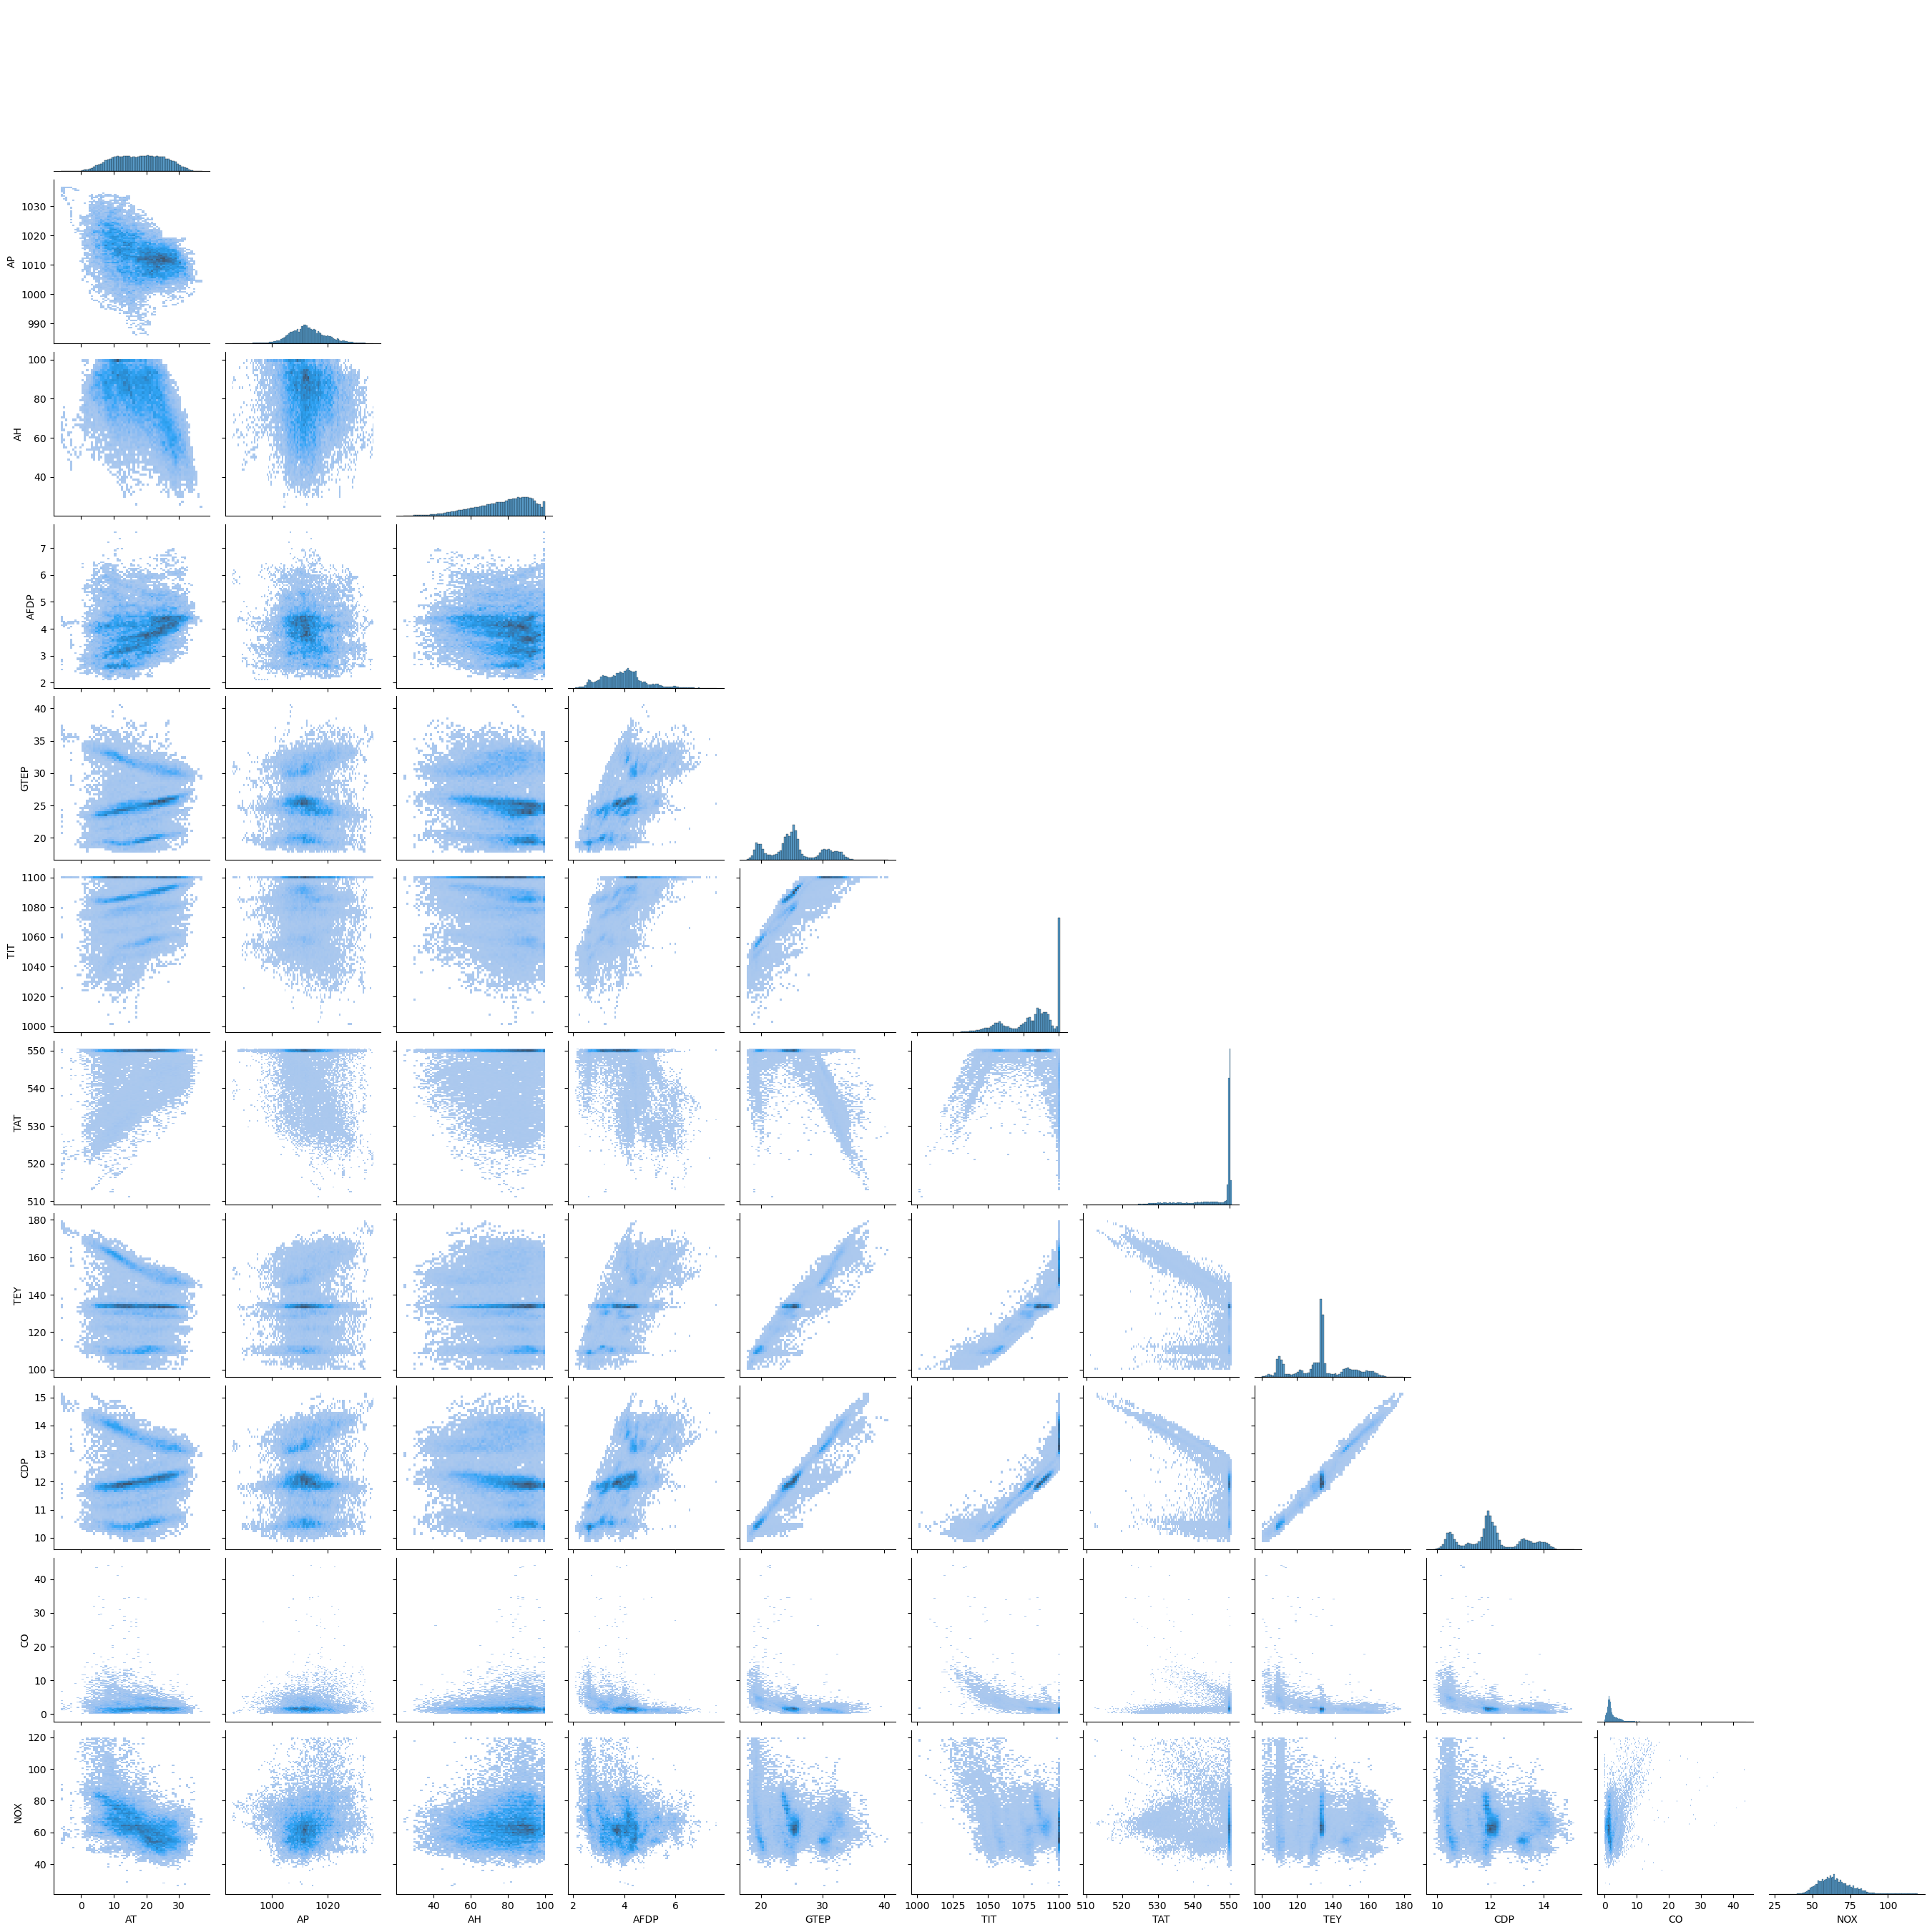

In [10]:
sns.pairplot(df, corner=True, kind='hist');

Видно, что между некоторыми параметрами наблюдается довольно сильная корреляция. А у признака **CO** явно присутствует много выбросов. Рассмотрим распределение величин

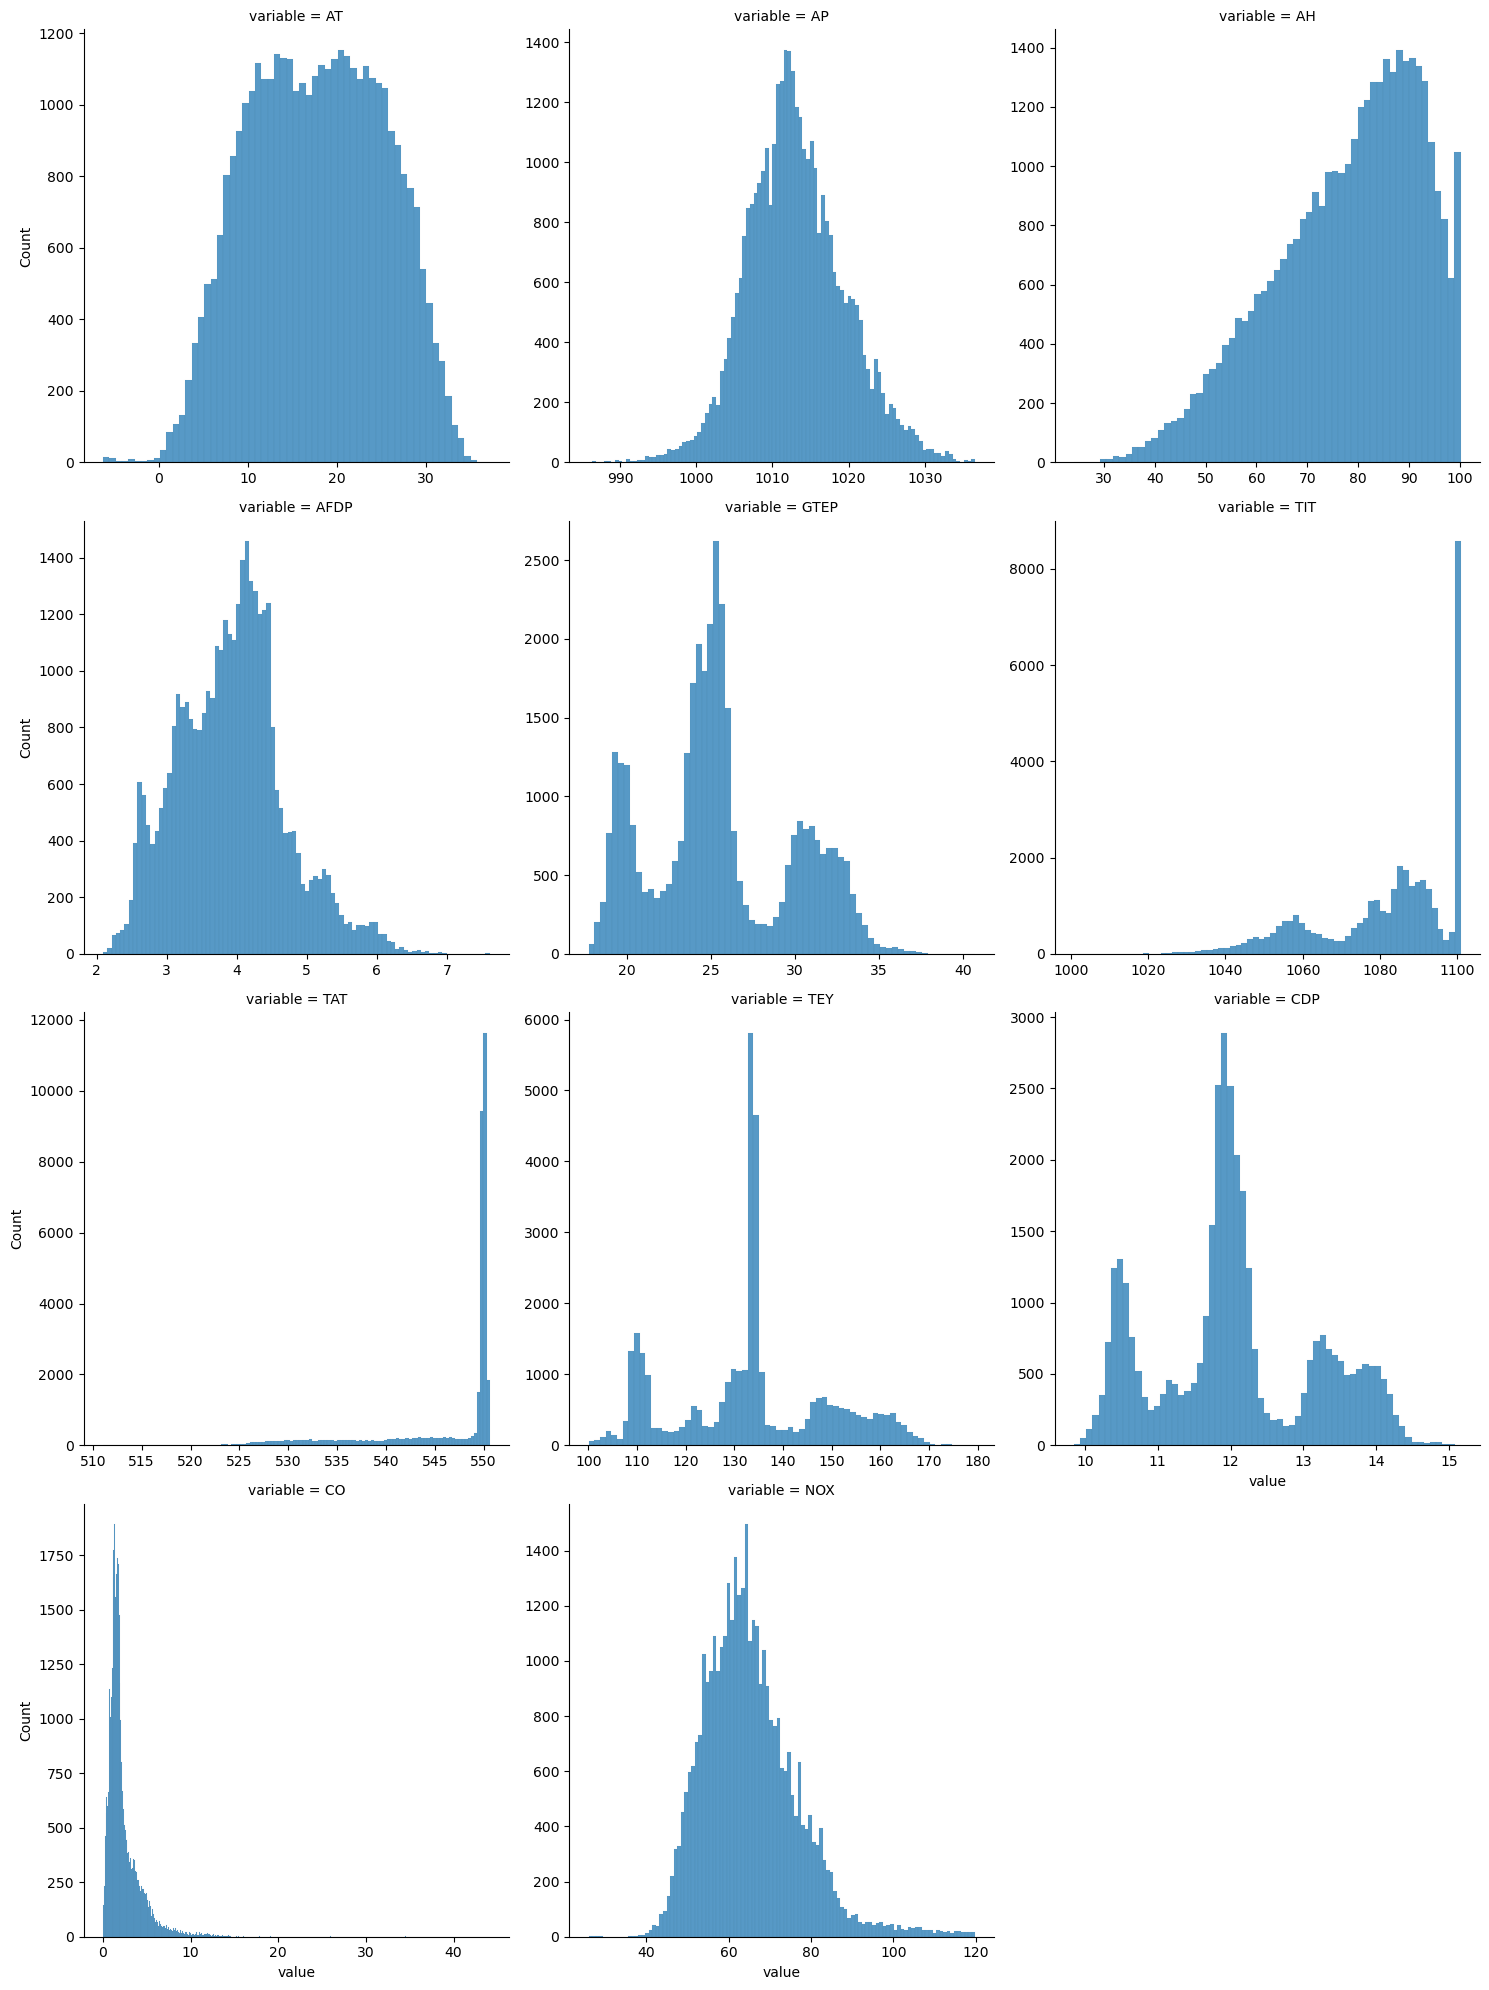

In [11]:
sns.displot(
    x='value',
    data=df.melt(value_vars=df),
    col='variable',
    kind='hist',
    col_wrap=3,
    facet_kws={'sharex':False, 'sharey':False},
    common_bins=False
);

Нормально распределены только температура и давление. У влажности есть перекос в сторону более высоких значений что может быть объяснено размещением большей части ГТУ в прибрежной зоне. В значениях выбросов вредных веществ явно присутствуют аномалии. Что касается остальных параметров, то их распределения вызывают много вопросов.

Рассмотрим отдельно выбросы

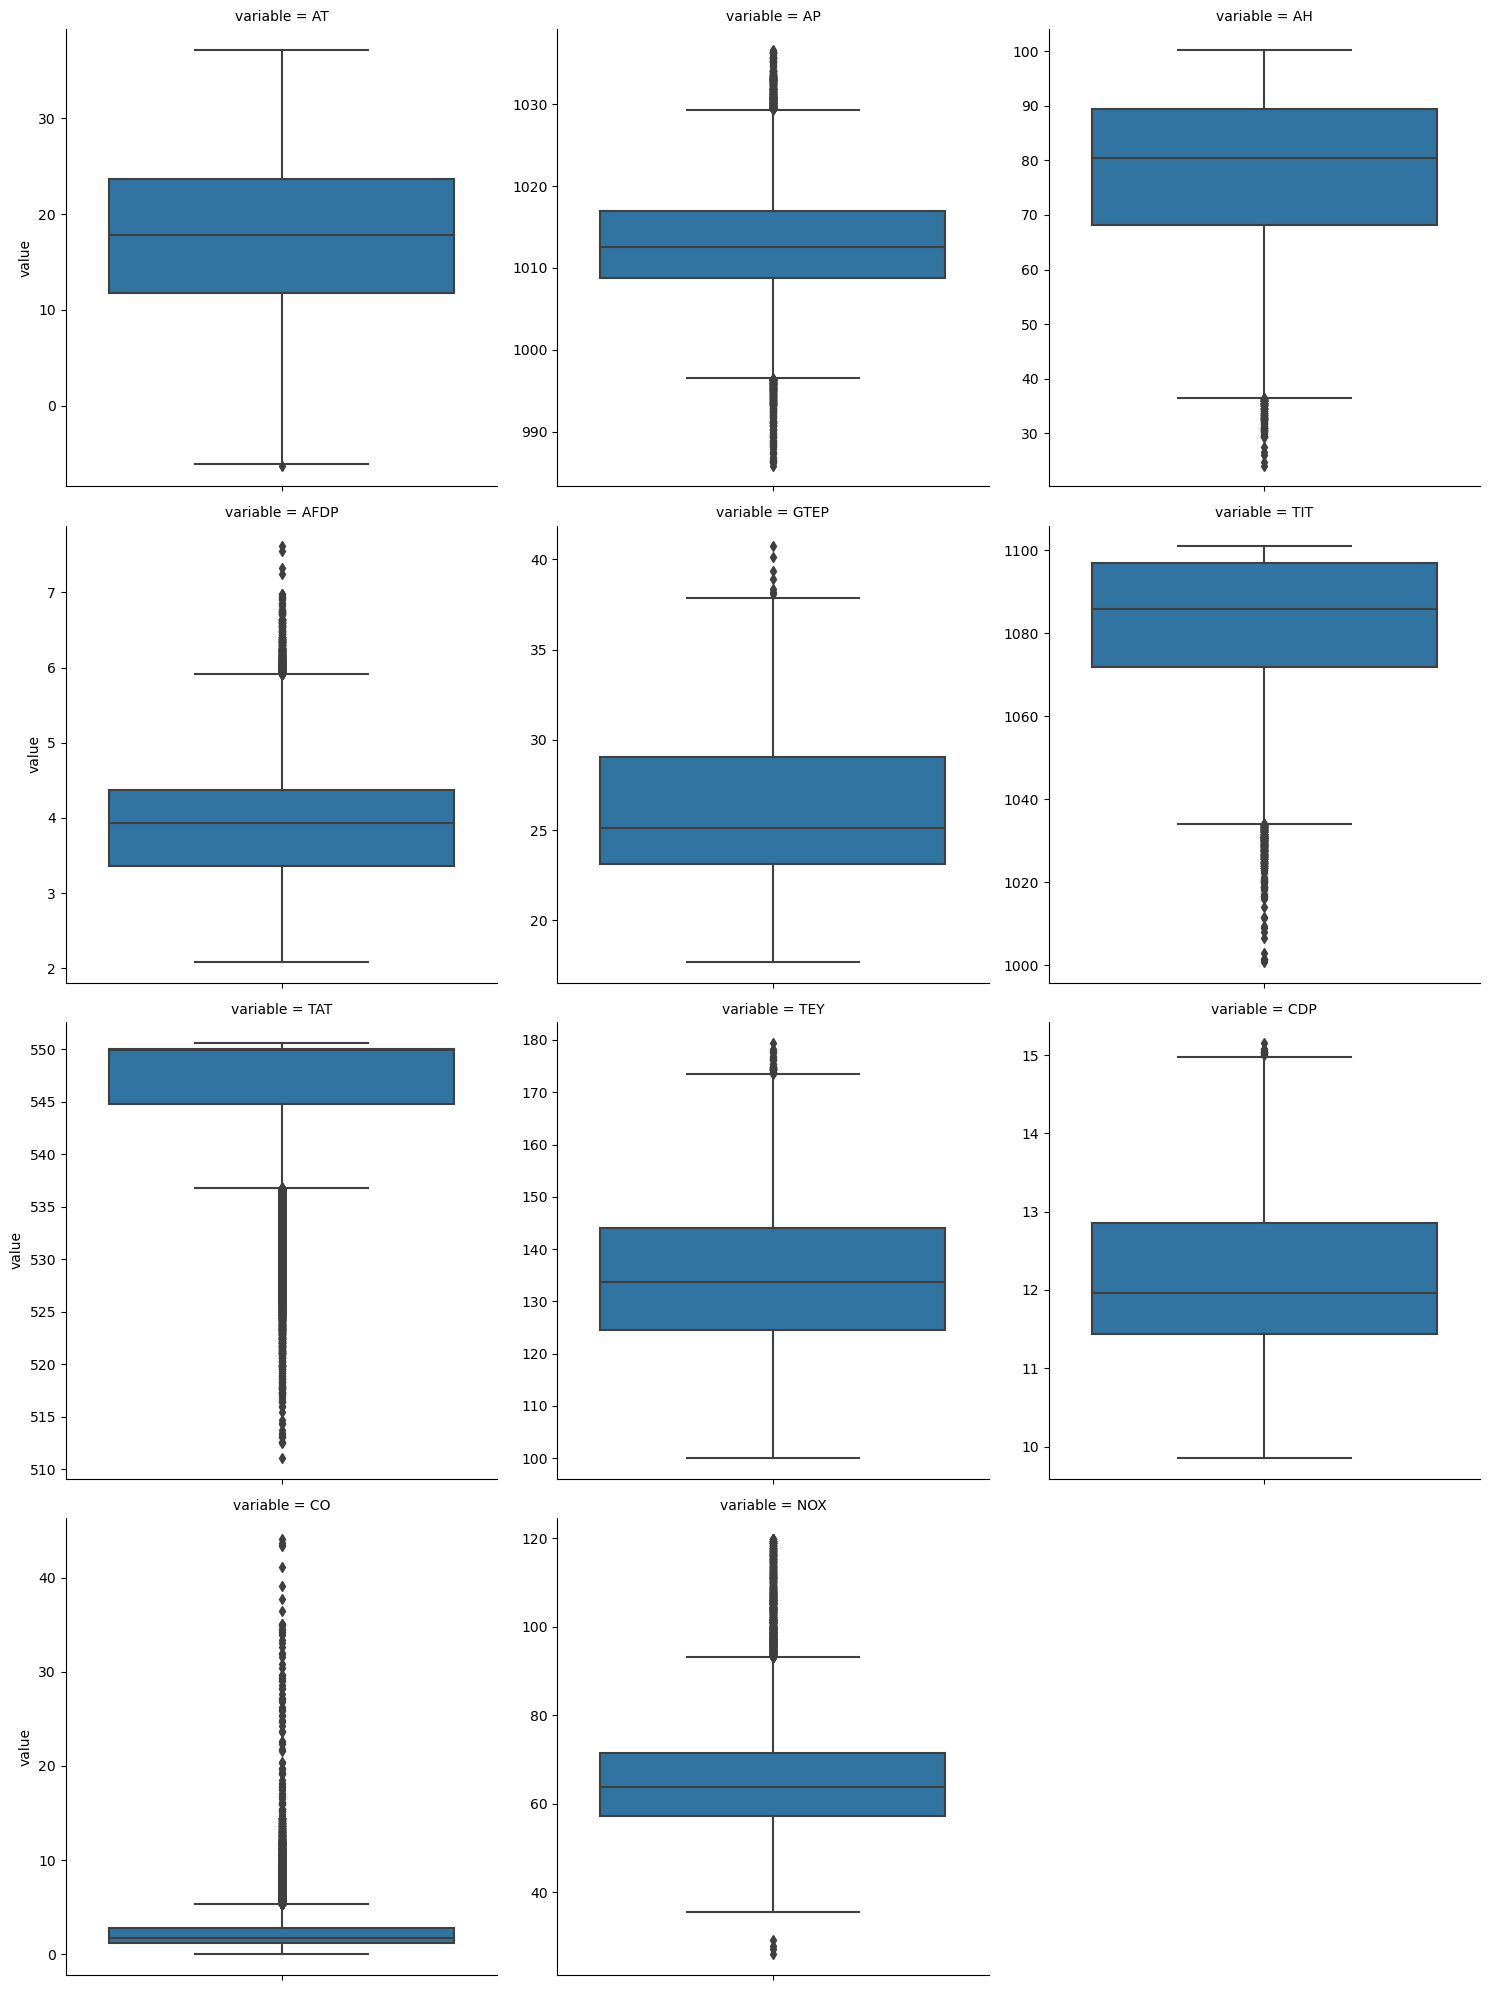

In [12]:
sns.catplot(
    y='value',
    data=df.melt(value_vars=df.columns),
    col='variable',
    kind='box',
    col_wrap=3,
    sharex=False, 
    sharey=False,
);

Да, есть много аномалий. При этом некоторые значения, которые являются аномалиями по отношению к интерквартильному размаху, могут быть вполне и реальными значениями. Например, если в качестве топлива применяется не природный газ, а жидкое топливо (например, керасин), то и температуры как перед турбиной, так и после будут ниже. Но ГТУ на жидком топливе используются гораздо реже, чем на природном газе, поэтому таких значений меньше. 

Видим очень большое число выбросов среди значений по угарному газу. Как правило, повышенные значения СО среди продуктов сгорания могут быть тоже нормой, если турбина работает в переходных режимах (запуск, прогрев), но обычно эти режимы непродолжительны. Также на количество выбросов может влиять и тип топлива, и его качество. 

Ещё раз внимательнее посмотрим на графики **CO** и **NOX**

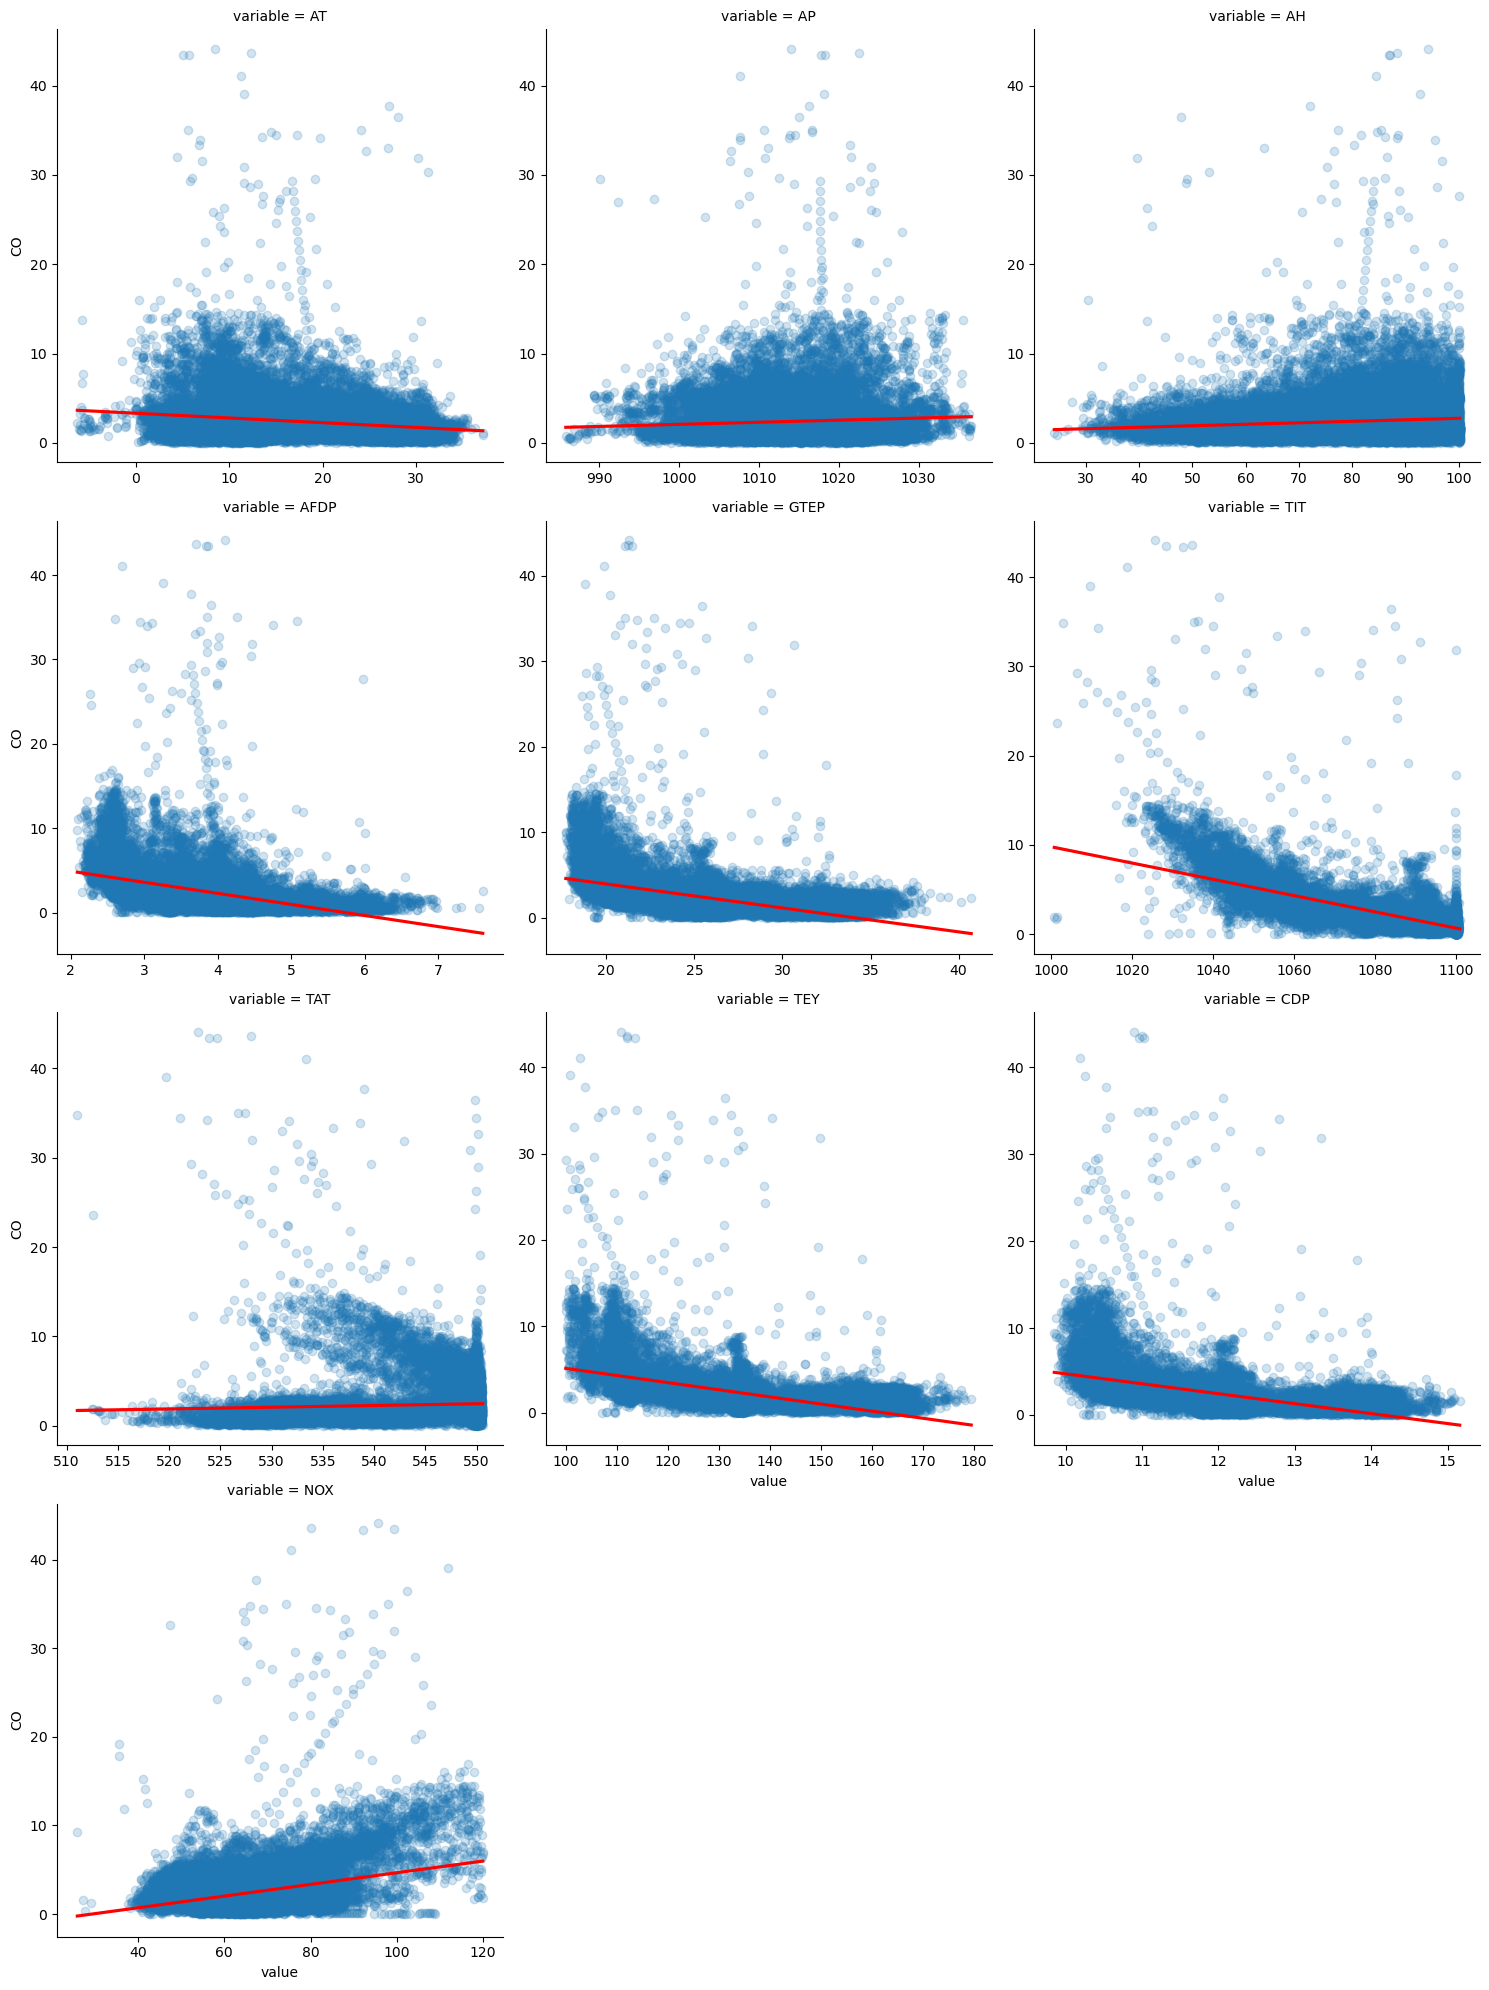

In [13]:
ax = sns.lmplot(
    x='value',
    y='CO',
    data=df.melt(id_vars='CO', value_vars=df),
    col='variable',
    col_wrap=3,
    sharex=False, 
    sharey=False,
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.2}
)
ax.tight_layout();

Хорошо прослеживаются зависимости, что с ростом **TEY** (здесь, скорей всего, имеется ввиду не расчётная мощность ГТУ, а измеренная текущая), **CDP**, **TIT** уменьшается количество выбросов СО 

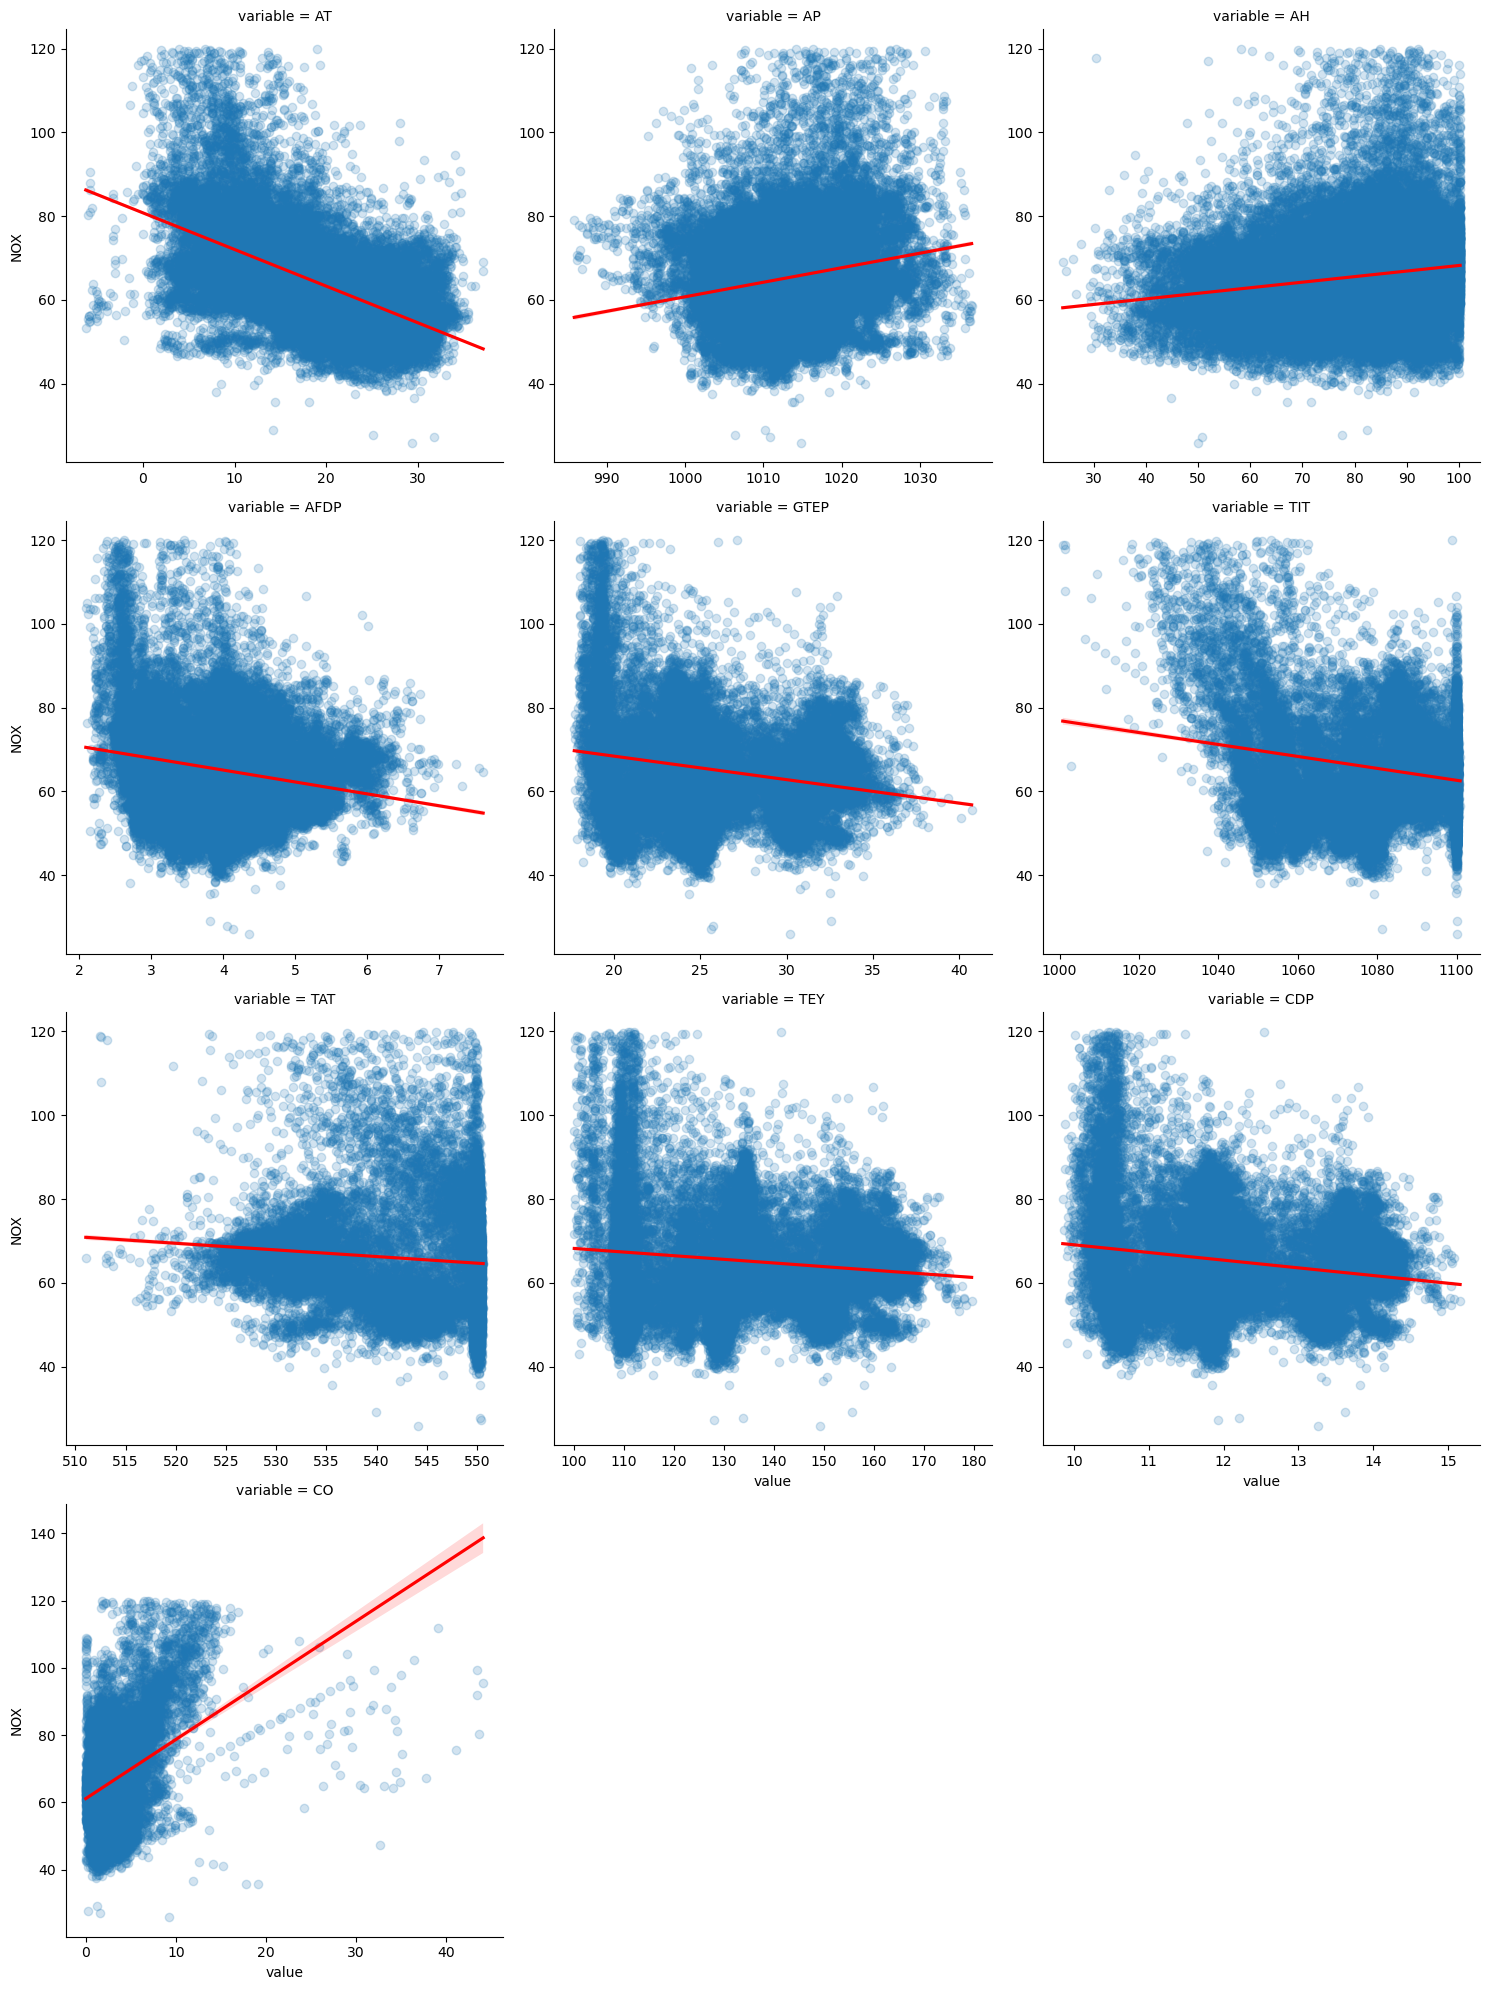

In [14]:
ax = sns.lmplot(
    x='value',
    y='NOX',
    data=df.melt(id_vars='NOX', value_vars=df),
    col='variable',
    col_wrap=3,
    sharex=False, 
    sharey=False,
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.2}
)
ax.tight_layout();

Здесь зависимости не столь очевидны. Но очень хороша видна зависимость между угарным газом и оксидами азота. Посмотрим на матрицу корреляций

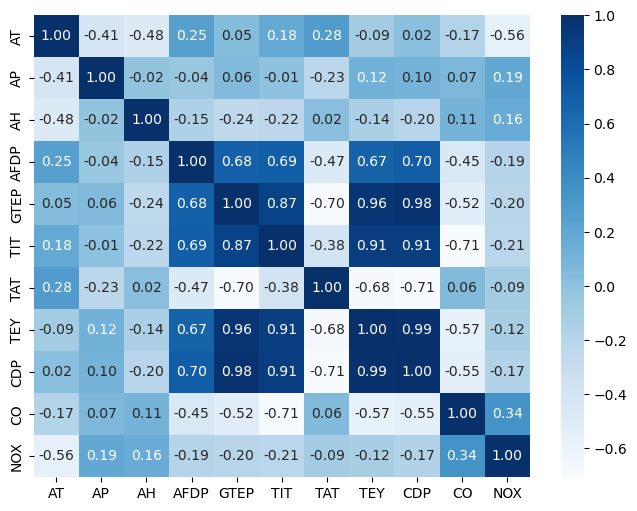

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df.corr(), 
    annot=True, 
    cmap='Blues',
    fmt='.2f',
);

Здесь параметры можно разделить на природные и технические. Природные - это, соответственно, температура воздуха, влажность и давление. Технические - это рабочие характеристики газотурбинных установок. Мы видим, что у технических параметров наблюдается довольно сильная корреляция друг с другом (кроме температуры после турбины). Технические и природные параметры коррелированы слабо, что вполне логично.

## 5. Моделирование <a class="anchor" id="5"></a>

### 5.1 Получение базовых оценок <a class="anchor" id="5.1"></a>

[Наверх](#0)

Пока ничего не будем делать с выбросами. Попробуем получить базовые оценки, от которых будем отталкиваться в дальнейшем

In [16]:
# Разделим датасет на тренировочный и тестовый
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

X_train = df_train.drop(['CO', 'NOX'], axis=1)
y_train = df_train[['CO', 'NOX']].copy()

# Масштабируем признаки
std = StandardScaler()
X_train_std = std.fit_transform(X_train)

In [17]:
lin_reg = LinearRegression()
svc_reg = SVR()
tre_reg = DecisionTreeRegressor(random_state=42)
rnd_reg = RandomForestRegressor(random_state=42)
xgb_reg = XGBRegressor(random_state=42, verbosity=0)

In [18]:
metrics = defaultdict(dict)
scorers = ['neg_mean_squared_error', 'neg_mean_absolute_error']
features = ['CO', 'NOX']
for feature in features:
    for reg in (
        lin_reg,
        svc_reg,
        tre_reg, 
        rnd_reg,
        xgb_reg,
        ):
        scores = cross_validate(reg, X_train_std, y_train[feature], scoring=scorers, n_jobs=-1)
        metrics[reg.__class__.__name__] = (
            metrics[reg.__class__.__name__] | 
            {
                f'{feature}_rmse': np.sqrt(-scores['test_neg_mean_squared_error']).mean(),
                f'{feature}_rmse_std': np.sqrt(-scores['test_neg_mean_squared_error']).std(),
                f'{feature}_mae': -scores['test_neg_mean_absolute_error'].mean(),
                f'{feature}_mae_std': scores['test_neg_mean_absolute_error'].std()
            })

In [19]:
pd.DataFrame(metrics).T.apply(pd.to_numeric).style.format('{:.3f}').background_gradient(cmap=plt.get_cmap('PuBu'), axis=0)

Как видно, лучший результат показал *RandomForestRegressor*. Немного хуже результат у *XGBRegressor*. Посмотрим на важность признаков

In [20]:
def plot_feature_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns
    plt.title(f'Важность признаков для {model.__class__.__name__}')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])

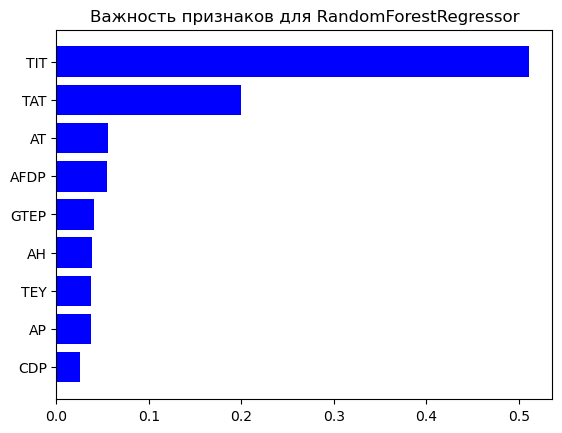

In [21]:
rnd_reg.fit(X_train_std, y_train['CO'])
plot_feature_importance(rnd_reg)

Здесь видно, основными признаками для данной модели являются температура до и после турбины

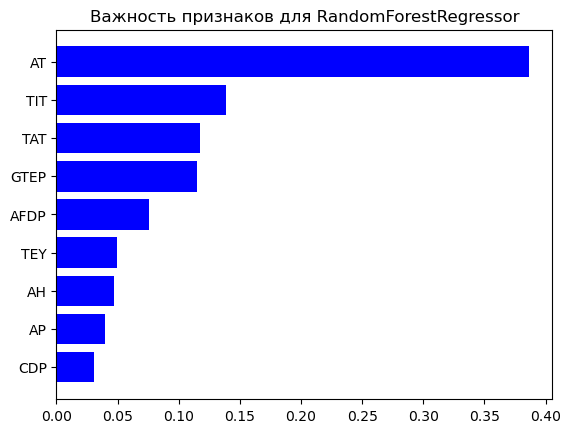

In [22]:
rnd_reg.fit(X_train_std, y_train['NOX'])
plot_feature_importance(rnd_reg)

Для **NOX** ключевым признаком является температура окружающего воздуха

### 5.2 Удаление выбросов с помощью межквартильного размаха <a class="anchor" id="5.2"></a>

[Наверх](#0)

Теперь удалим выбросы

In [23]:
def calculate_iqr_boundaries(series):
    q25 = series.quantile(0.25)
    q75 = series.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

In [24]:
boundaries = pd.DataFrame(calculate_iqr_boundaries(X_train))
boundaries

AT       AP          AH      AFDP       GTEP     TIT        TAT  \
0  -5.987   996.65   36.765125  1.814862  14.074125  1033.5  536.67125   
1  41.451  1029.05  120.942125  5.919563  38.101125  1135.1  558.06125   

      TEY        CDP  
0   94.53   9.259375  
1  173.95  15.034375

Удалим выбросы среди тренировочных данных

In [25]:
features_max = [f for f in boundaries.columns if (X_train[f]>boundaries[f].max()).sum()]
features_min = [f for f in boundaries.columns if (X_train[f]<boundaries[f].min()).sum()]

In [26]:
for f in features_max:
    X_train[f][X_train[f] > boundaries[f][1]] = boundaries[f][1]

In [27]:
for f in features_min:
    X_train[f][X_train[f] < boundaries[f][0]] = boundaries[f][0]

Посмотрим на графики

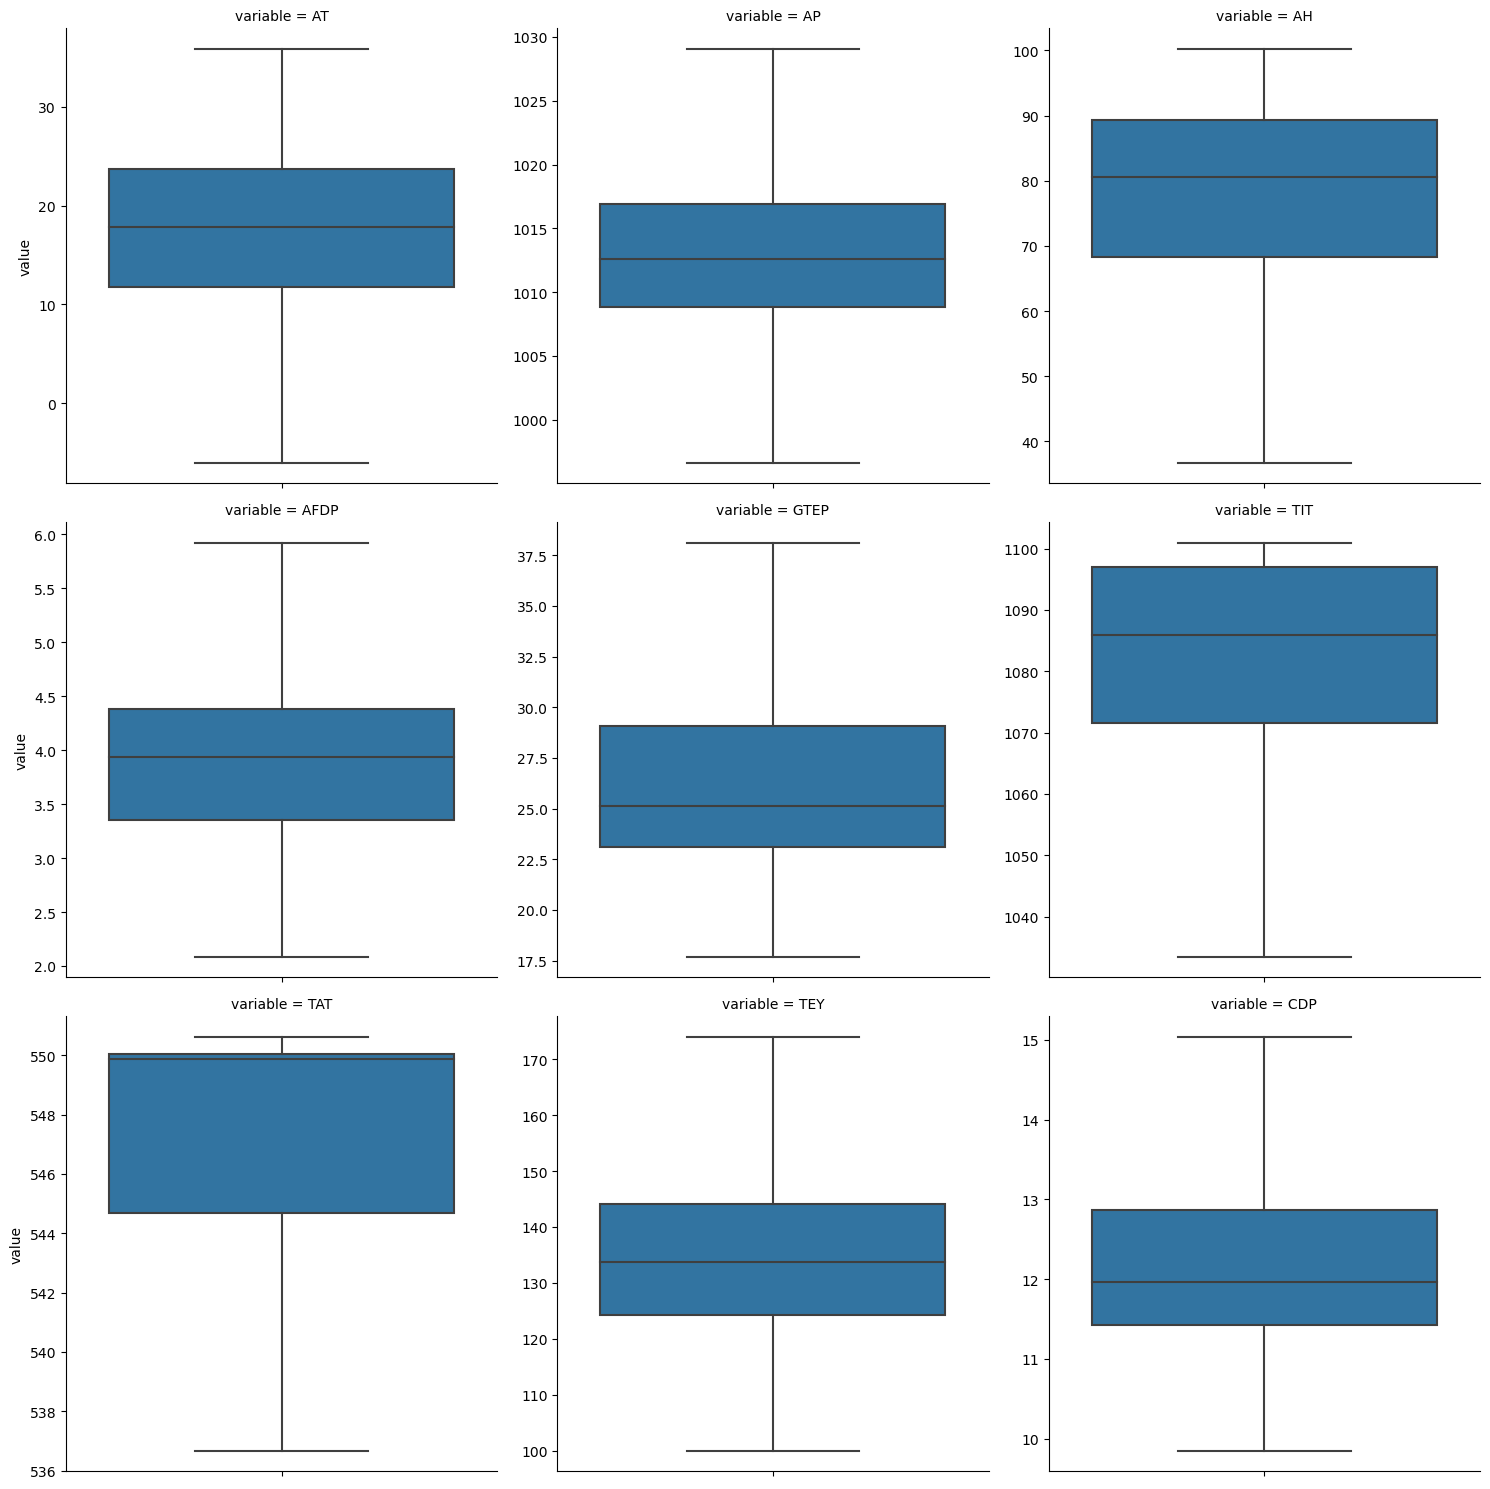

In [28]:
sns.catplot(
    y='value',
    data=X_train.melt(value_vars=X_train.columns),
    col='variable',
    kind='box',
    col_wrap=3,
    sharex=False, 
    sharey=False,
);

Отлично, выбросов нет! Масштабируем новые значения

In [29]:
X_train_std = std.fit_transform(X_train)

In [30]:
metrics1 = defaultdict(dict)
scorers = ['neg_mean_squared_error', 'neg_mean_absolute_error']
features = ['CO', 'NOX']
for feature in features:
    for reg in (
        lin_reg,
        svc_reg,
        tre_reg, 
        rnd_reg,
        xgb_reg,
        ):
        scores = cross_validate(reg, X_train_std, y_train[feature], scoring=scorers, n_jobs=-1)
        metrics1[reg.__class__.__name__] = (
            metrics1[reg.__class__.__name__] | 
            {
                f'{feature}_rmse': np.sqrt(-scores['test_neg_mean_squared_error']).mean(),
                f'{feature}_rmse_std': np.sqrt(-scores['test_neg_mean_squared_error']).std(),
                f'{feature}_mae': -scores['test_neg_mean_absolute_error'].mean(),
                f'{feature}_mae_std': scores['test_neg_mean_absolute_error'].std()
            })

In [31]:
pd.DataFrame(metrics1).T.apply(pd.to_numeric).style.format('{:.3f}').background_gradient(cmap=plt.get_cmap('PuBu'), axis=0)

Сравним полученные результаты с базовыми оценками

In [32]:
def diff_metrics(a, b):
    a1 = pd.DataFrame(a).apply(pd.to_numeric)
    b1 = pd.DataFrame(b).apply(pd.to_numeric)
    columns = a.keys()
    index = list(a.values())[0].keys()
    diff = pd.DataFrame((a1.values - b1.values)/b1.values*100, columns=columns, index=index)
    return diff.T.style.format('{:.2f}').background_gradient(cmap=plt.get_cmap('coolwarm'), axis=None, vmin=-10, vmax=10)

In [33]:
diff_metrics(metrics1, metrics)

Существенных изменений не произошло, а по некоторым параметрам даже стало хуже. Этому есть простое объяснение: мы удалил выбросы среди признаков, но при этом осталось очень большое число выбросов среди целевых значений. Чтобы исправить ситуацию, нам нужно понять, какие объекты считать аномальными и не использовать их, а обучение проводить на корректных значениях. Попробуем для этого применить кластеризацию *DBSCAN*.

### 5.3 Удаление выбросов с помощью DBSCAN <a class="anchor" id="5.3"></a>

[Наверх](#0)

Попробуем проделать следующие шаги:
- с помощью DBSCAN определим выбросы на всём тренировочном датасете;
- обучим модель только на индексах центральных образцов тренировочных данных;
- с помощью метода ближайших соседей научимся предсказывать выбросы среди тестовых данных.

In [34]:
df_train_std = StandardScaler().fit_transform(df_train)
df_train_std = pd.DataFrame(df_train_std, columns=df_train.columns, index=df_train.index)

db = DBSCAN(eps=1.9, min_samples=40, n_jobs=-1)
db.fit(df_train_std)

DBSCAN(eps=1.9, min_samples=40, n_jobs=-1)

Посмотрим на количество кластеров и выбросов

In [35]:
unique, counts = np.unique(db.labels_, return_counts=True)
np.c_[unique, counts]

array([[   -1,   138],
       [    0, 29248]], dtype=int64)

Видим небольшое количество выбросов. Создадим копию датасета и новый признак, в который сохраним полученные метки

In [36]:
df_db = df_train.copy()
df_db['label'] = db.labels_

И ещё раз посмотрим на графики целевых параметров. Красным цветом обозначим выбросы

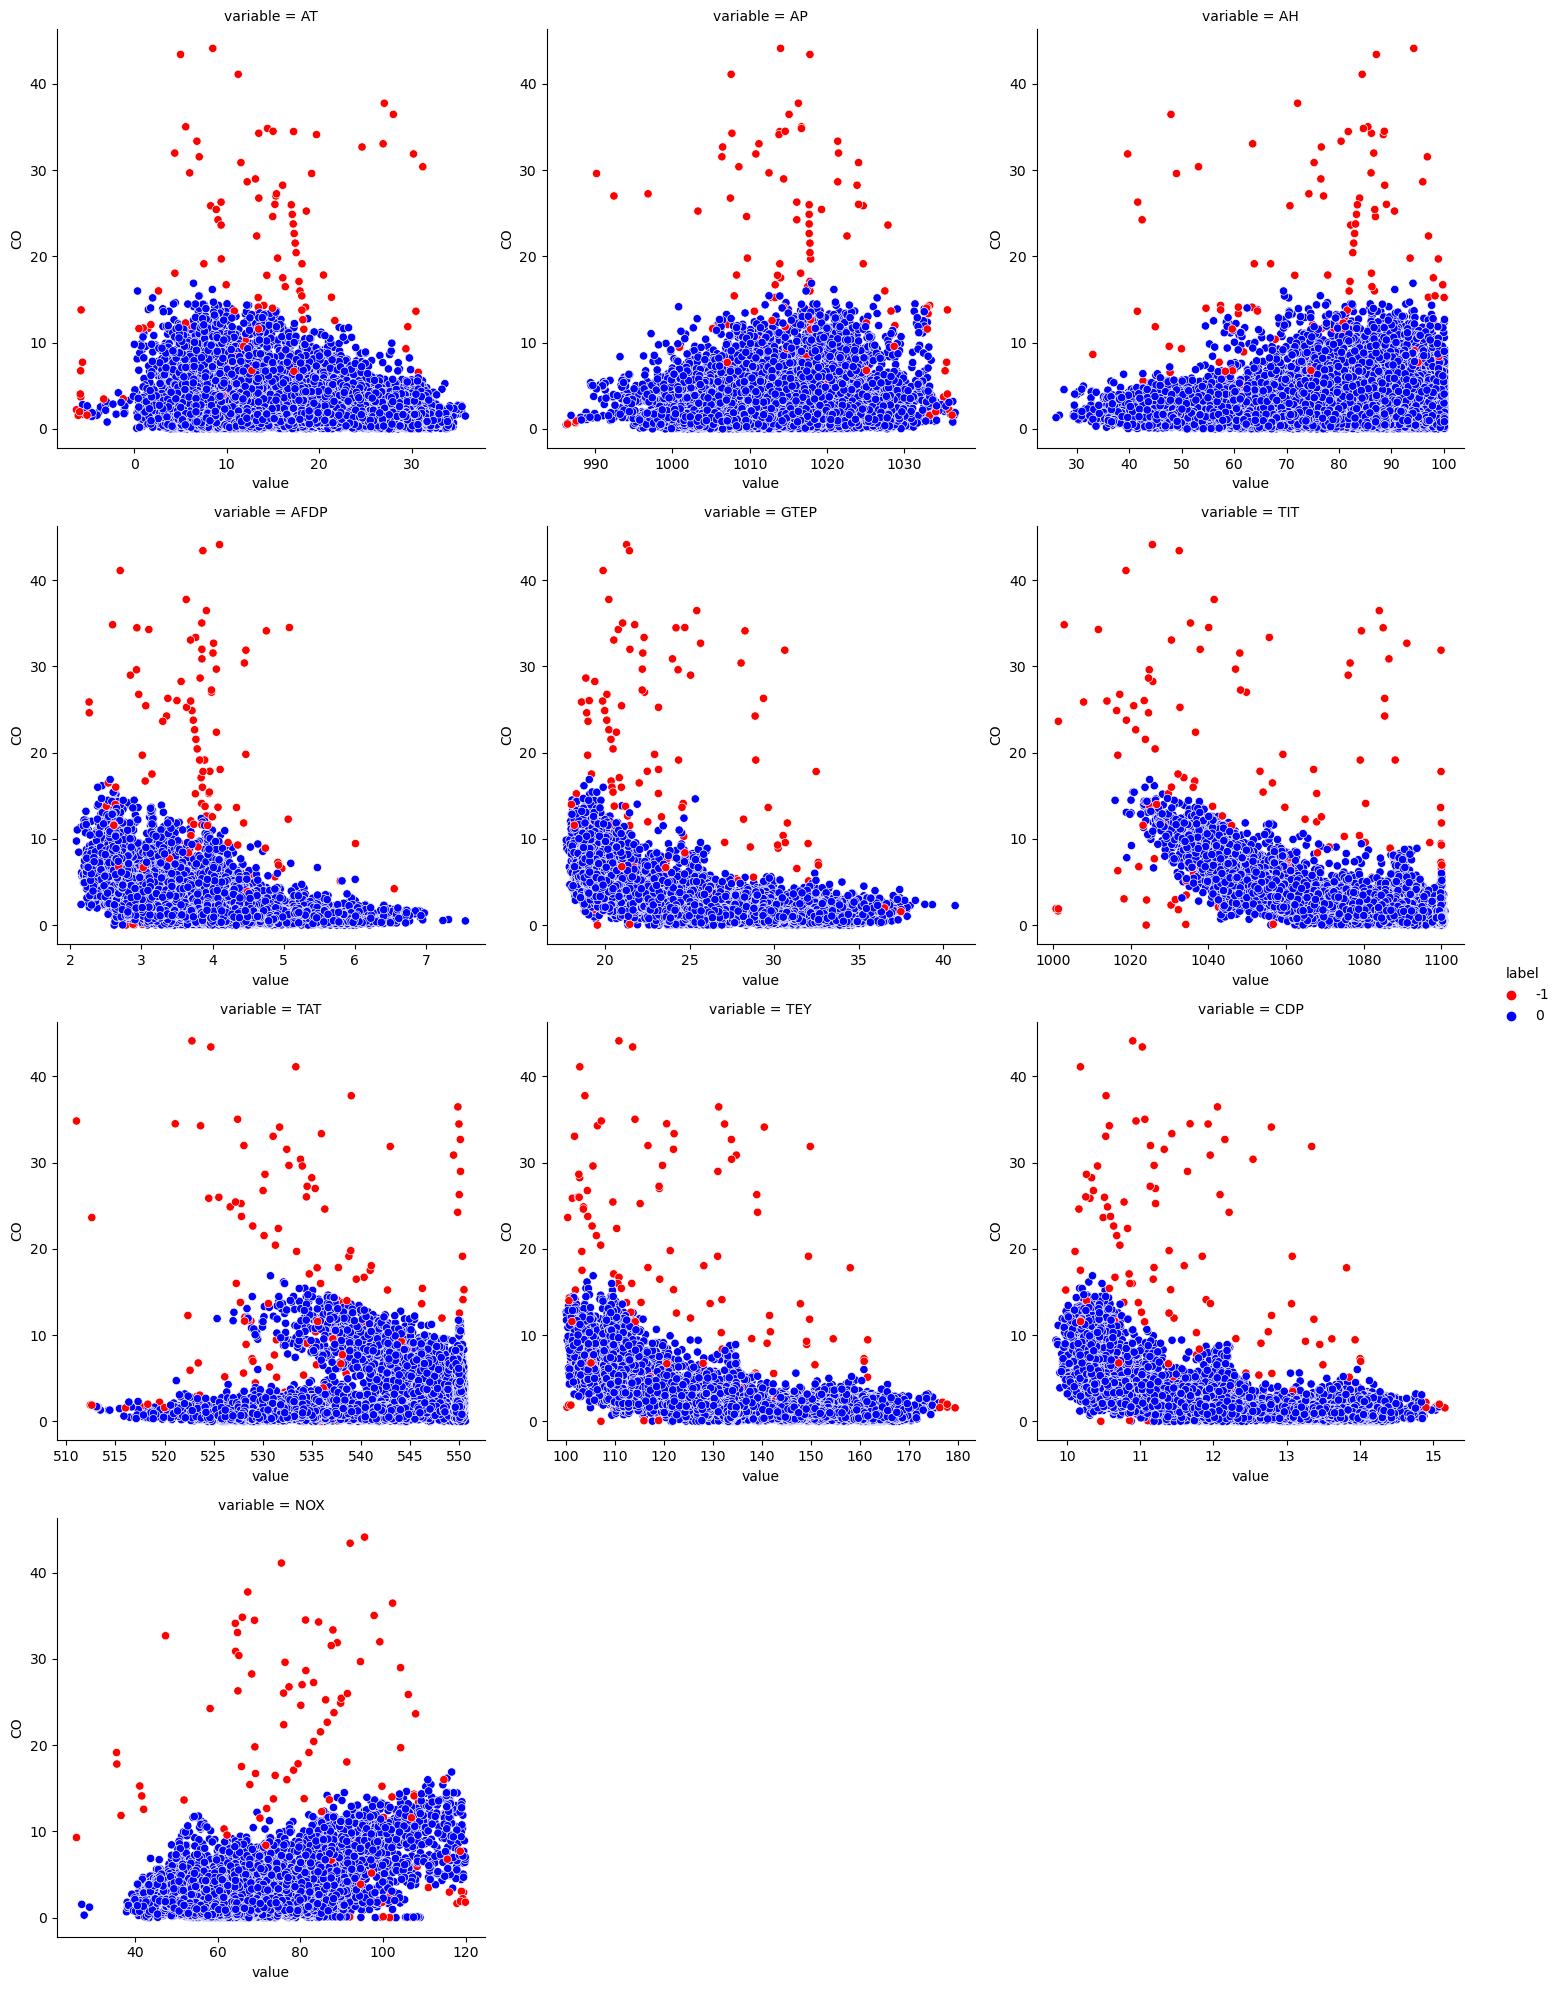

In [37]:
ax = sns.relplot(
    x='value',
    y='CO',
    data=df_db.melt(id_vars=['CO', 'label'], value_vars=df_db),
    col='variable',
    col_wrap=3,
    hue='label',
    palette=['r', 'b'],
    facet_kws=dict(sharex=False, sharey=False)
)
ax.tight_layout();

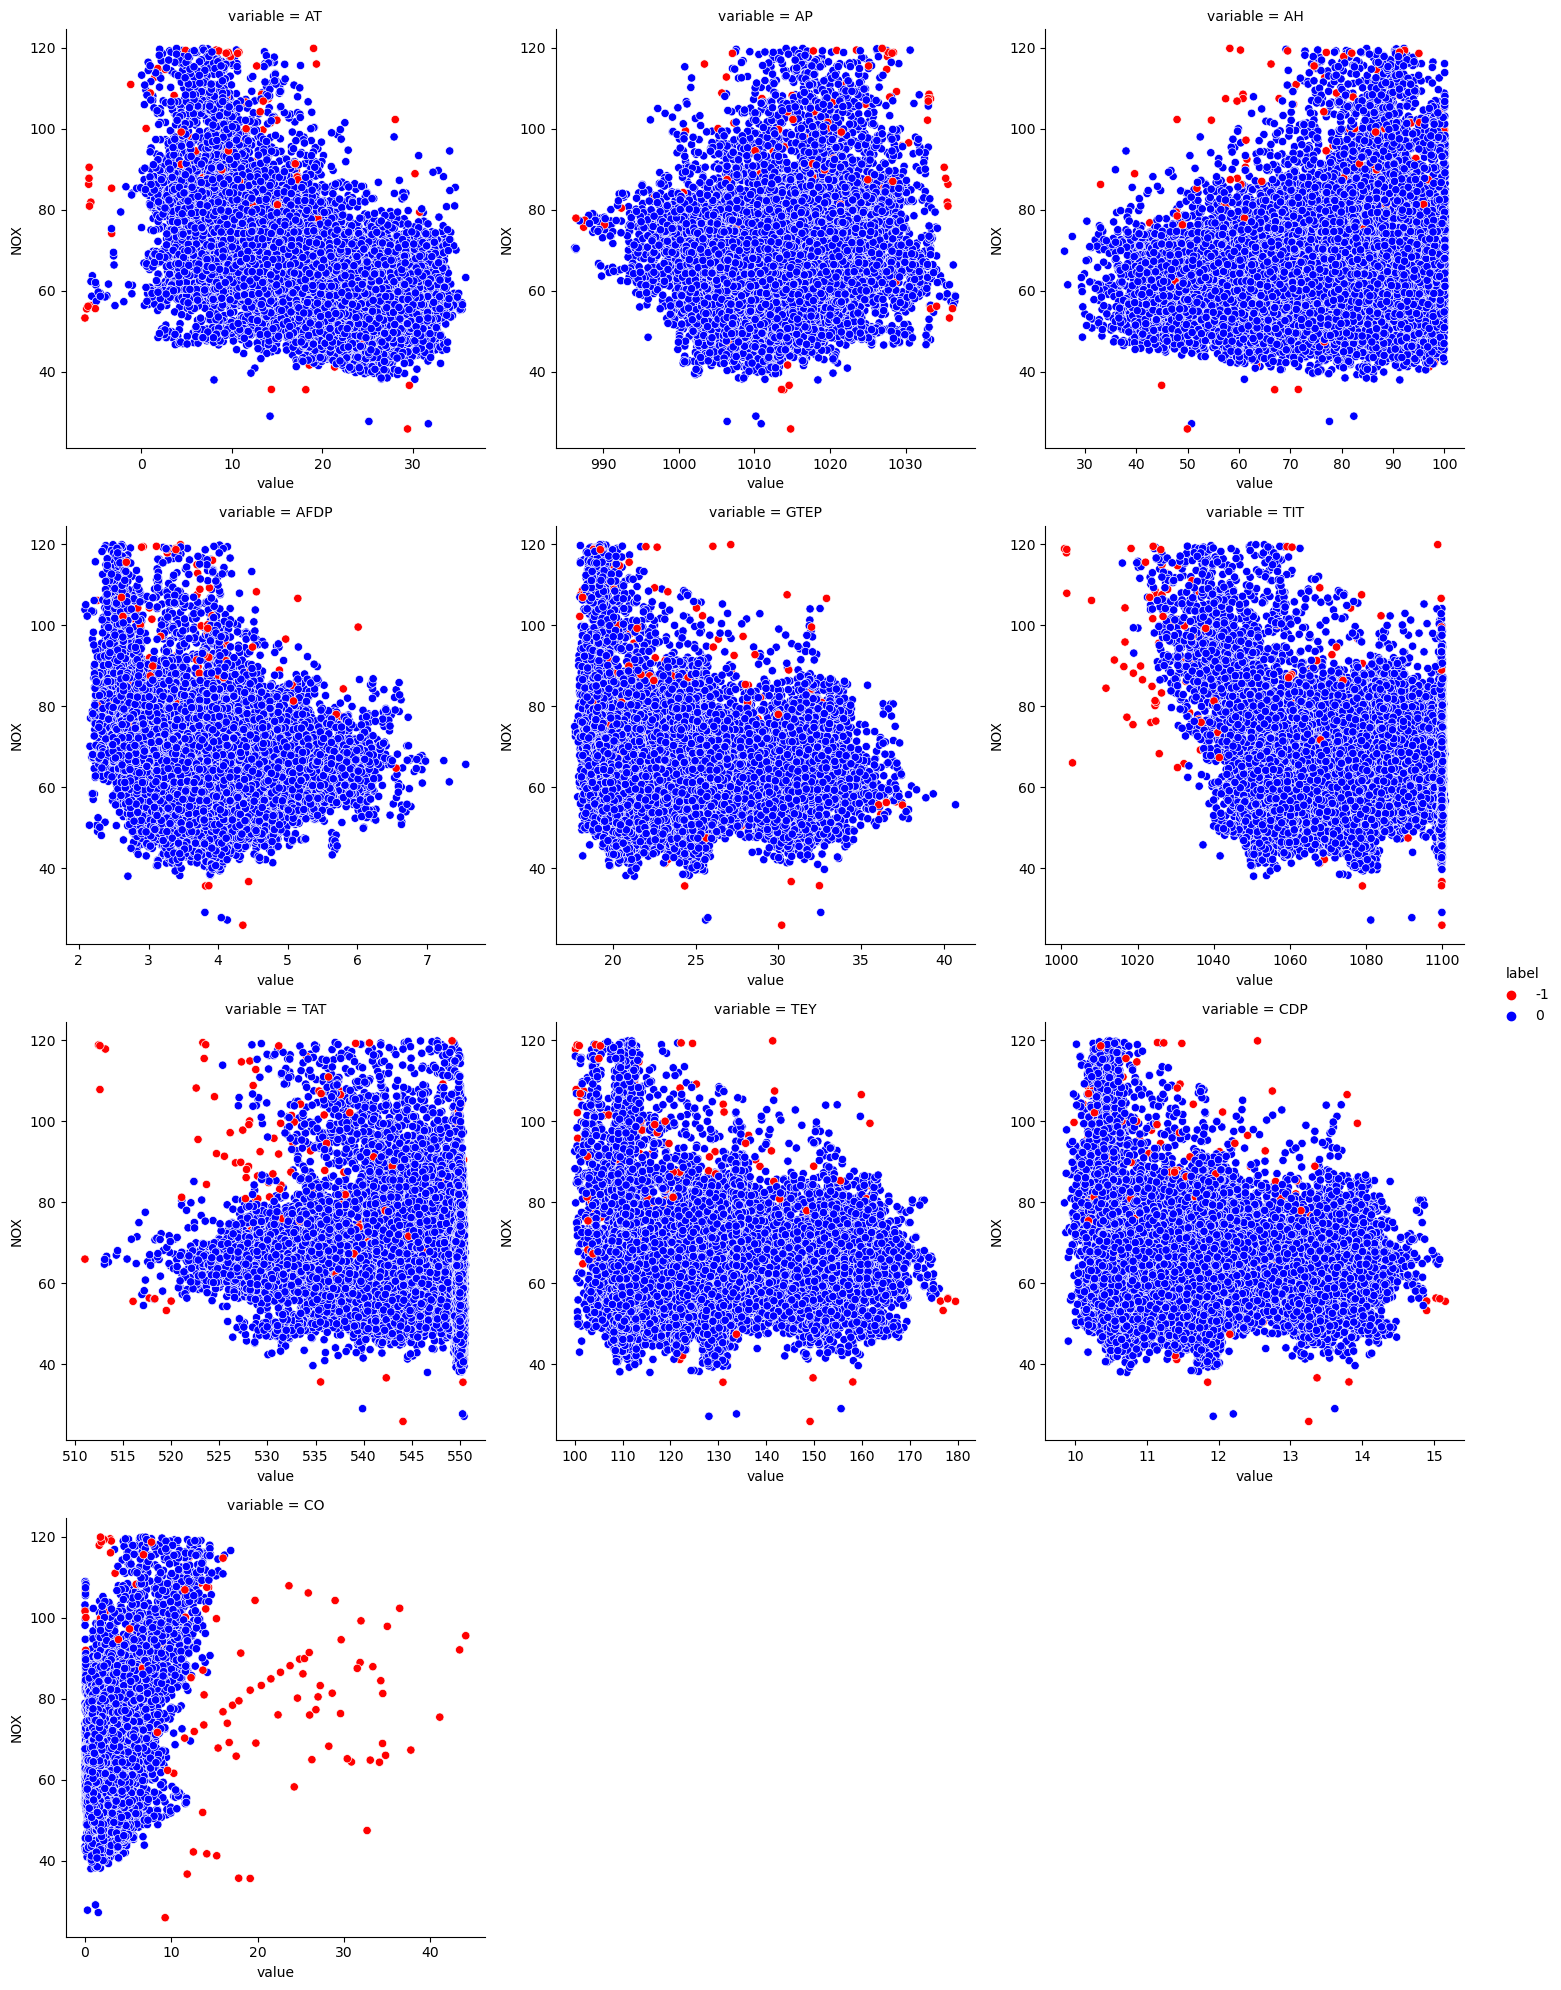

In [38]:
ax = sns.relplot(
    x='value',
    y='NOX',
    data=df_db.melt(id_vars=['NOX', 'label'], value_vars=df_db),
    col='variable',
    col_wrap=3,
    hue='label',
    palette=['r', 'b'],
    facet_kws=dict(sharex=False, sharey=False)
)
ax.tight_layout();

В целом, получилось довольно неплохо. Теперь получим индексы центральных образцов 

In [39]:
idx = db.core_sample_indices_

И посчитаем точность на тренировочной выборке с учётом центральных образцов

In [40]:
X_train = df_train.drop(['CO', 'NOX'], axis=1)
y_train = df_train[['CO', 'NOX']].copy()

X_test = df_test.drop(['CO', 'NOX'], axis=1)
y_test = df_test[['CO', 'NOX']].copy()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [41]:
metrics2 = defaultdict(dict)
scorers = ['neg_mean_squared_error', 'neg_mean_absolute_error']
features = ['CO', 'NOX']
for feature in features:
    for reg in (
        lin_reg,
        svc_reg,
        tre_reg, 
        rnd_reg,
        xgb_reg,
        ):
        scores = cross_validate(reg, X_train_std[idx], y_train[feature].iloc[idx], scoring=scorers, n_jobs=-1)
        metrics2[reg.__class__.__name__] = (
            metrics2[reg.__class__.__name__] | 
            {
                f'{feature}_rmse': np.sqrt(-scores['test_neg_mean_squared_error']).mean(),
                f'{feature}_rmse_std': np.sqrt(-scores['test_neg_mean_squared_error']).std(),
                f'{feature}_mae': -scores['test_neg_mean_absolute_error'].mean(),
                f'{feature}_mae_std': scores['test_neg_mean_absolute_error'].std()
            })

In [42]:
pd.DataFrame(metrics2).T.apply(pd.to_numeric).style.format('{:.3f}').background_gradient(cmap=plt.get_cmap('PuBu'), axis=0)

Сравним полученные значения

In [43]:
diff_metrics(metrics2, metrics)

Отличный результат! И снова лучше всех *RandomForestRegressor*

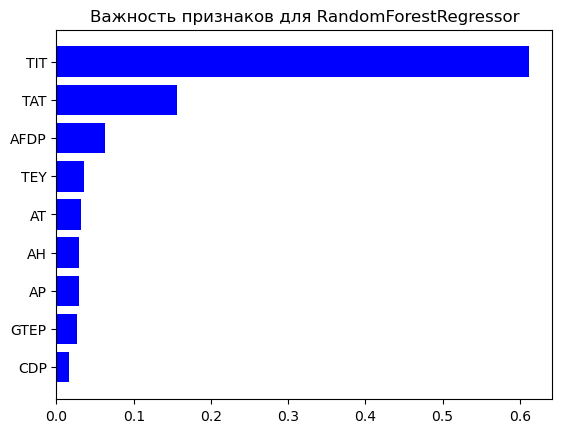

In [44]:
rnd_reg.fit(X_train_std[idx], y_train['CO'].iloc[idx])
plot_feature_importance(rnd_reg)

Видно, что повысилась важность признака **TIT**

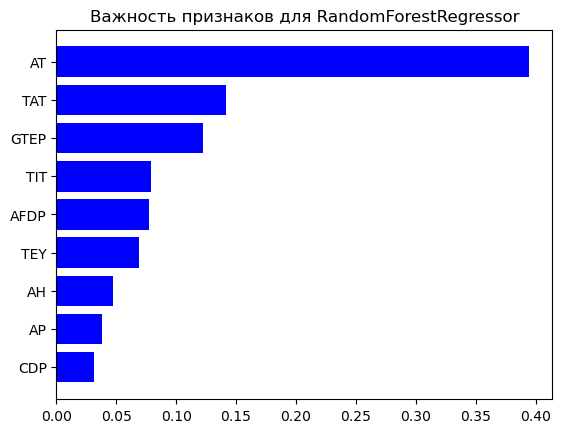

In [45]:
rnd_reg.fit(X_train_std[idx], y_train['NOX'].iloc[idx])
plot_feature_importance(rnd_reg)

Здесь наоборот, важность **TIT** уменьшилась

## 6. Проверка на тестовой выборке <a class="anchor" id="6"></a>

[Наверх](#0)

Теперь займёмся подготовкой тестовых данных. Обучим классификатор на основе к-ближайших соседей, где в качестве меток возьмём значения из *db.labels_*. 

In [46]:
# 0 - это выброс, 1 - нормальное значение
labels = db.labels_ + 1

In [47]:
knn = KNeighborsClassifier()

С помощью решётчатого поиска подберём оптимальное количество соседей

In [48]:
param_grid = {'n_neighbors' : np.arange(2, 50)}
knn_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=5)
knn_search.fit(X_train_std, labels)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             scoring='accuracy')

Посмотрим на оптимальное значение параметра

In [49]:
best_params = knn_search.best_params_
best_params

{'n_neighbors': 3}

In [50]:
knn_search.best_score_

0.9966310383619561

Обучим классификатор с оптимальными параметрами

In [51]:
knn = knn_search.best_estimator_
knn.fit(X_train_std, labels)

KNeighborsClassifier(n_neighbors=3)

Предскажем выбросы среди тестовых данных (в том числе выбросы среди целевых параметров)

In [52]:
y_pred = knn.predict(X_test_std)

Посмотрим, сколько получилось выбросов

In [53]:
unique, counts = np.unique(y_pred, return_counts=True)
np.c_[unique, counts]

array([[   0,   27],
       [   1, 7320]], dtype=int64)

Попробуем поднять порог с помощью метода *kneighbors*. Вычислим расстояния

In [54]:
y_dist, _  = knn.kneighbors(X_test_std, n_neighbors=1)

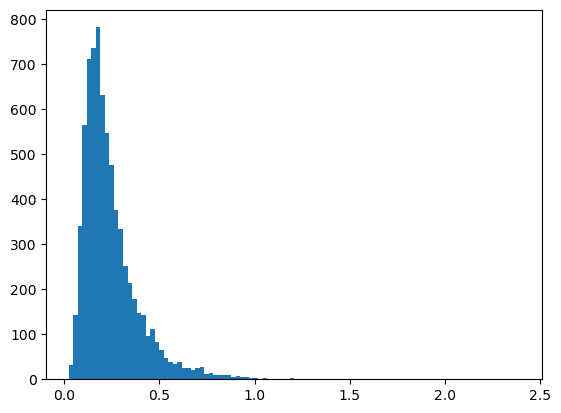

In [55]:
plt.hist(y_dist, bins=100);

Установим порог на уровне 0.9, то есть всё, что находится выше, будем считать выбросом

In [56]:
y_pred[y_dist.ravel()>0.9] = 0

Посмотрим графики целевых параметров, на которых отдельно выделим выбросы

In [57]:
df_db_test = df_test.copy()
df_db_test['label'] = y_pred

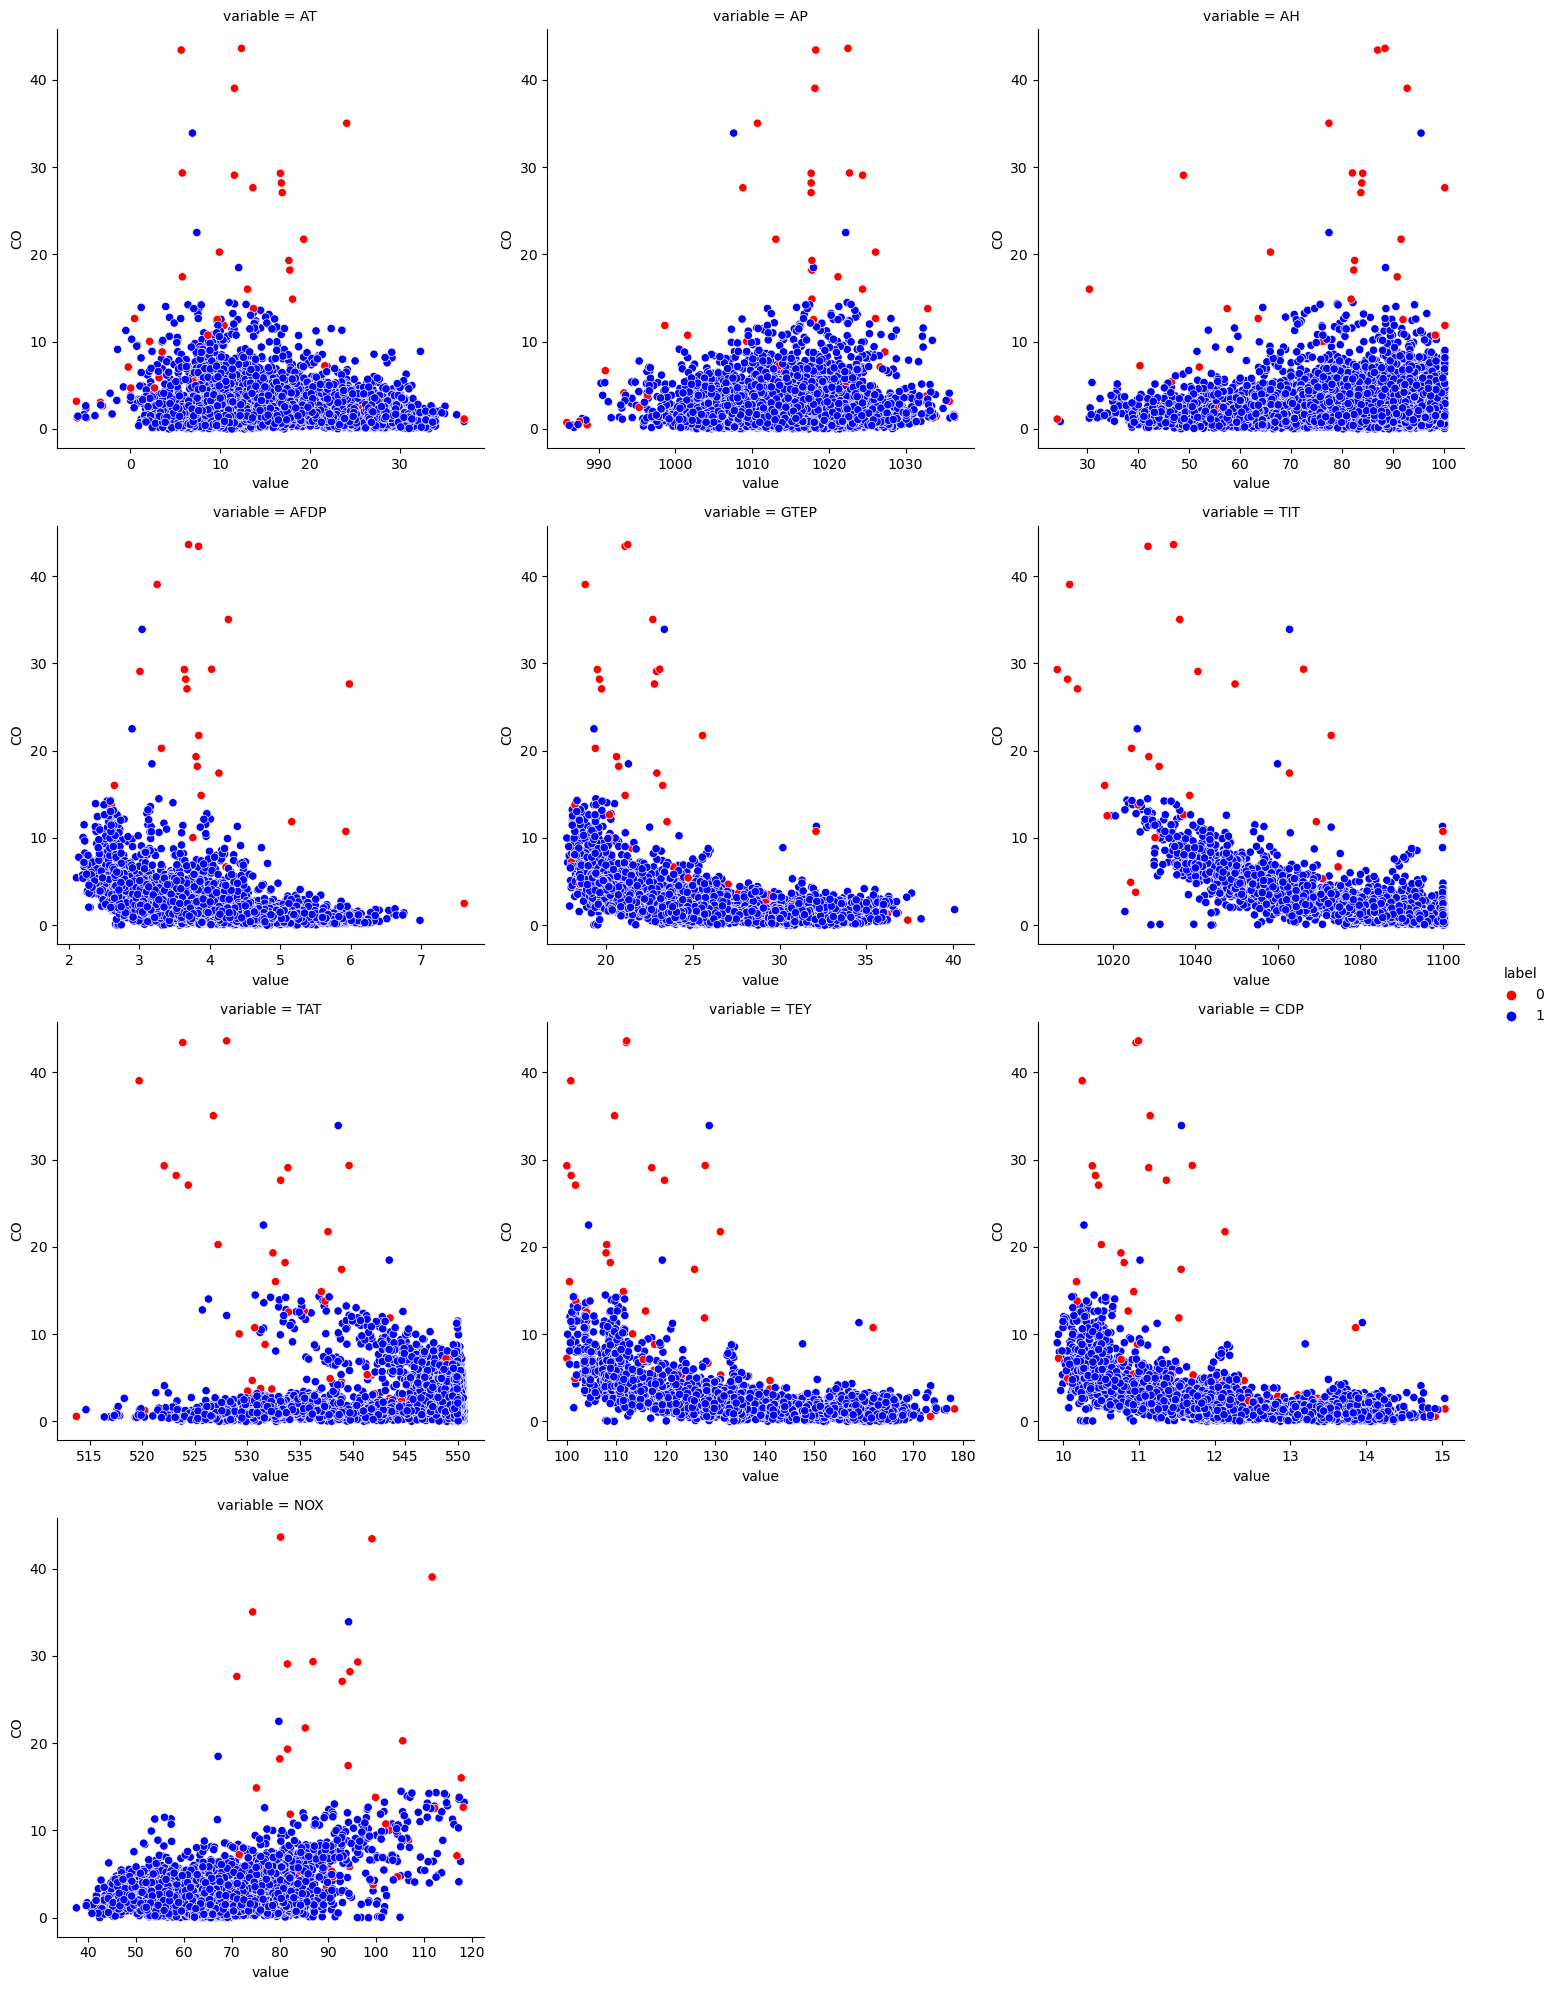

In [58]:
ax = sns.relplot(
    x='value',
    y='CO',
    data=df_db_test.melt(id_vars=['CO', 'label'], value_vars=df_db_test),
    col='variable',
    col_wrap=3,
    hue='label',
    palette=['r', 'b'],
    facet_kws=dict(sharex=False, sharey=False)
)
ax.tight_layout();

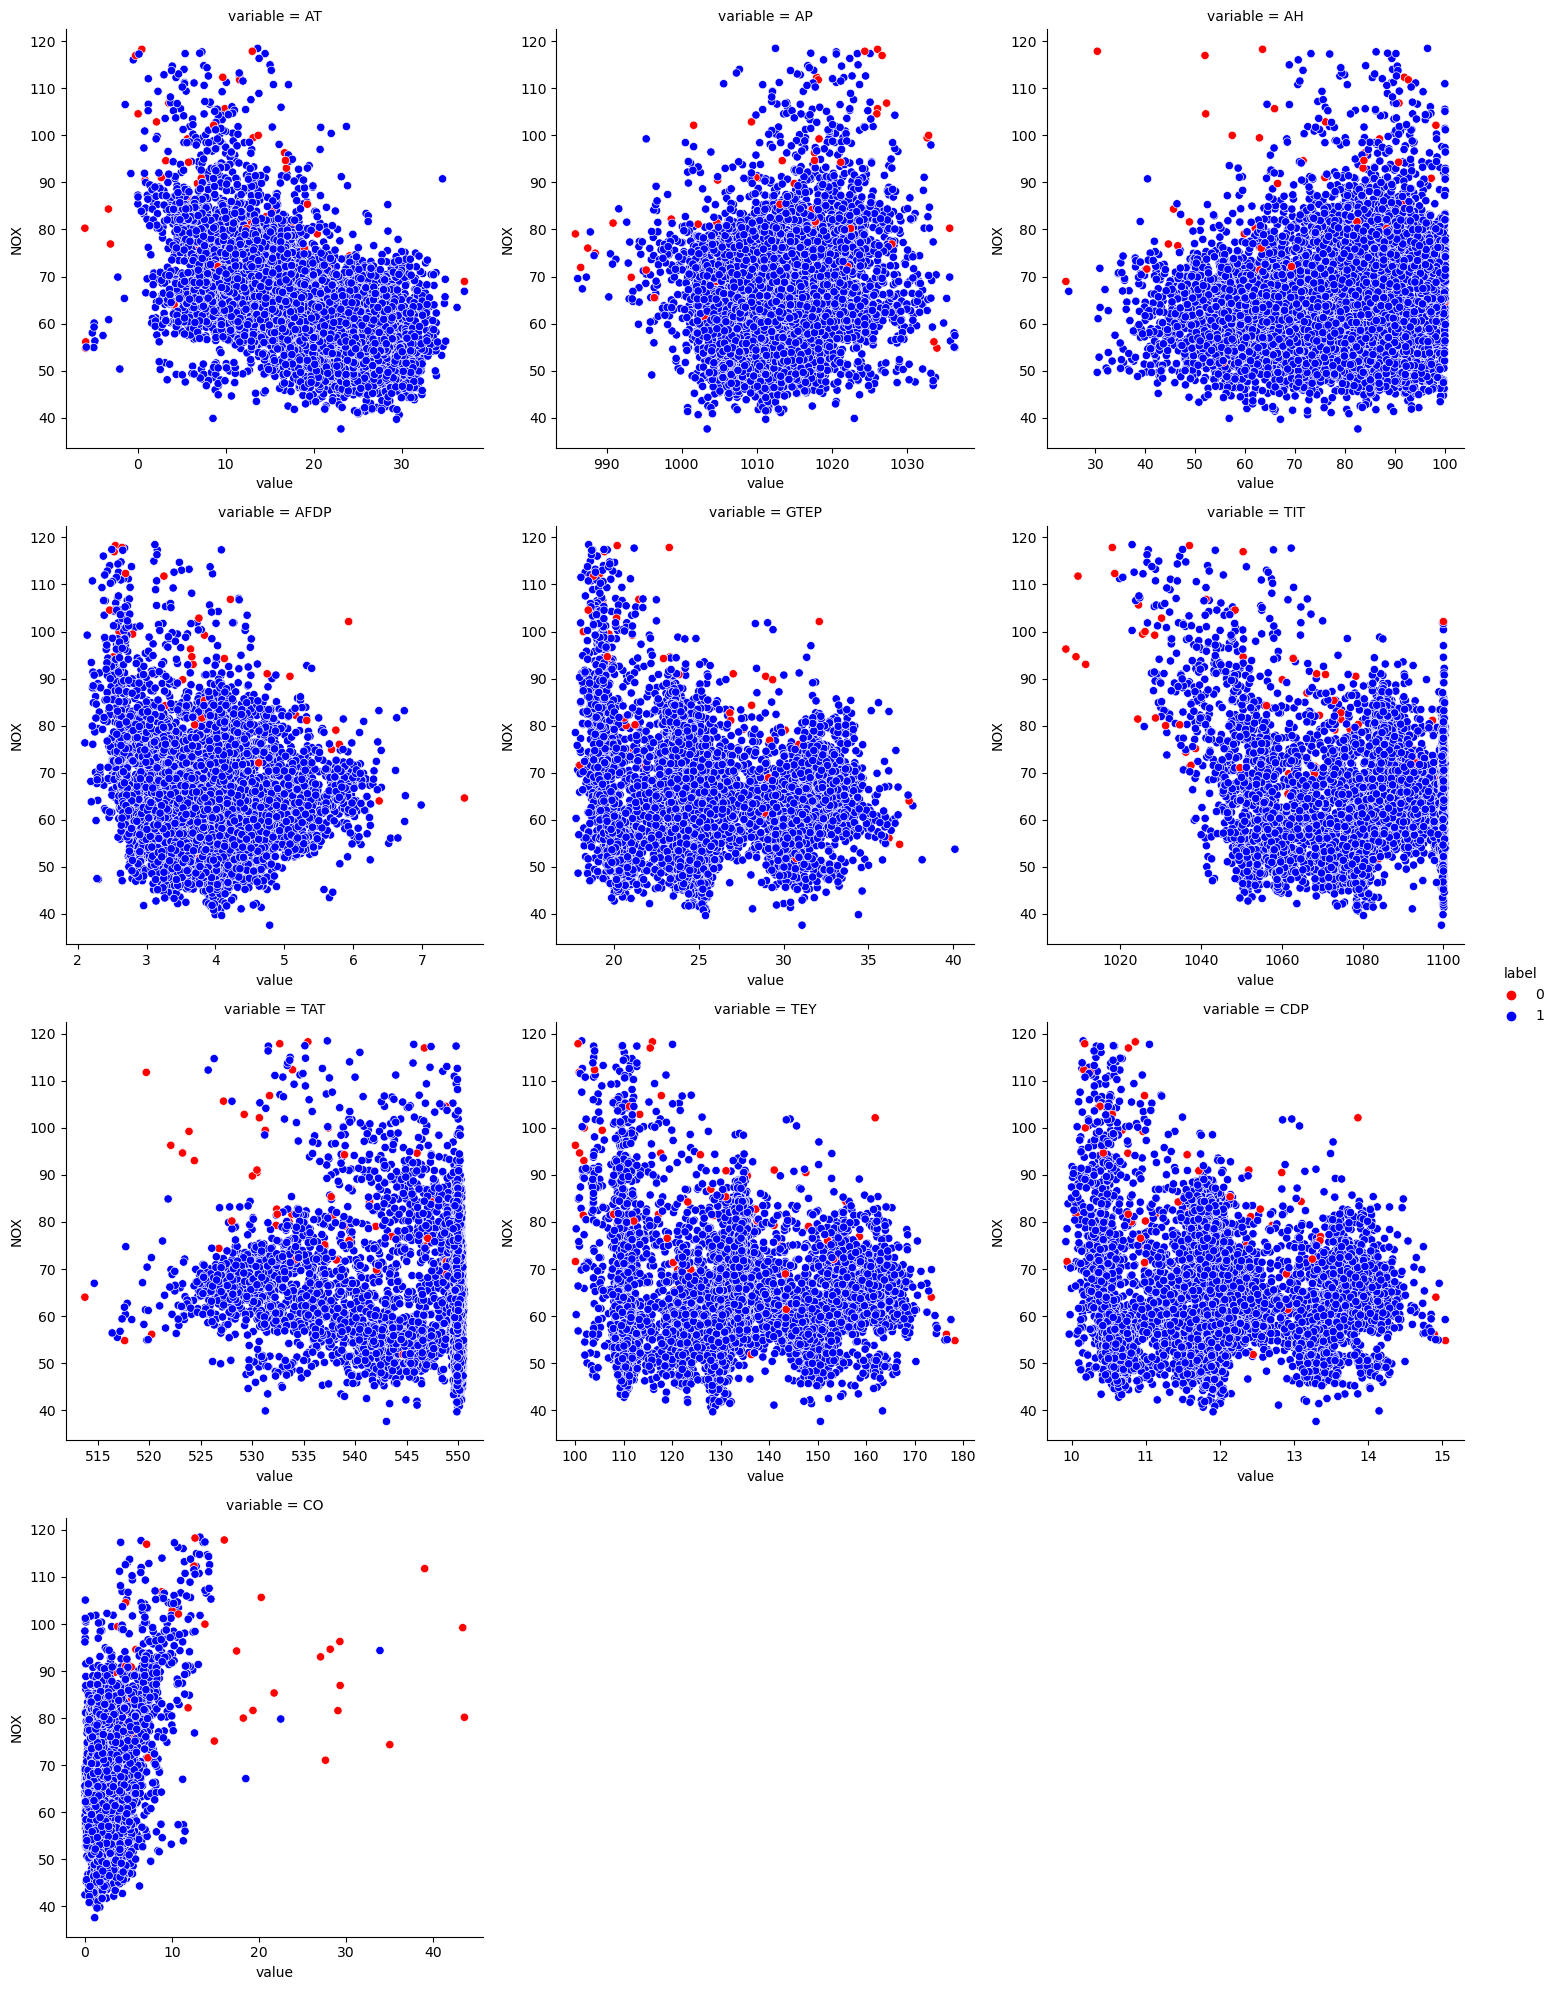

In [59]:
ax = sns.relplot(
    x='value',
    y='NOX',
    data=df_db_test.melt(id_vars=['NOX', 'label'], value_vars=df_db_test),
    col='variable',
    col_wrap=3,
    hue='label',
    palette=['r', 'b'],
    facet_kws=dict(sharex=False, sharey=False)
)
ax.tight_layout();

Как видно, нам довольно-таки неплохо удалось предсказать выбросы среди тестовых данных. В предсказании будем использовать только нормальные значения. Сохраним в отдельную переменную индексы этих значений

In [60]:
idxs = np.where(y_pred>0)[0]

In [61]:
metrics3 = defaultdict(dict)
features = ['CO', 'NOX']
for feature in features:
    for reg in (
        lin_reg,
        svc_reg,
        tre_reg, 
        rnd_reg,
        xgb_reg,
        ):
        reg.fit(X_train_std[idx], y_train[feature].iloc[idx])
        metrics3[reg.__class__.__name__] = (
            metrics3[reg.__class__.__name__] | 
            {
                f'{feature}_rmse': mean_squared_error(y_test[feature].iloc[idxs], 
                                                       reg.predict(X_test_std[idxs]), squared=False),
                f'{feature}_mae': mean_absolute_error(y_test[feature].iloc[idxs], 
                                                       reg.predict(X_test_std[idxs]))
            })

In [62]:
pd.DataFrame(metrics3).T.apply(pd.to_numeric).style.format('{:.3f}').background_gradient(cmap=plt.get_cmap('PuBu'), axis=0)

## 7. Заключение <a class="anchor" id="7"></a>

[Наверх](#0)

Лучший результат показал случайный лес. Немного хуже показал себя *XGBRegressor*. Возможно, если провести поиск оптимальных гиперпараметров, то *XGBRegressor* покажет наилучшую точность. Значения RMSE и MSE на тестовой выборке почти не отличаются от значений на тренировочной выборке